# Machine Learning Model Evaluation for Injury Prediction

This notebook evaluates three machine learning models (LASSO, Random Forest, XGBoost) for injury prediction using two different data splitting strategies.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import (classification_report, roc_auc_score, 
                           precision_recall_curve, average_precision_score,
                           roc_curve, confusion_matrix)
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

## 1. Data Loading 

In [2]:
def load_data(split_type='athlete_based'):
    """Load preprocessed train/test data for a specific split type."""
    base_path = f'../simulated_data/processed/{split_type}/'
    
    X_train = pd.read_csv(f'{base_path}X_train.csv')
    X_test = pd.read_csv(f'{base_path}X_test.csv')
    y_train = pd.read_csv(f'{base_path}y_train.csv').values.ravel()
    y_test = pd.read_csv(f'{base_path}y_test.csv').values.ravel()
    
    return X_train, X_test, y_train, y_test

## 2. Model Evaluation Functions

In [3]:
def evaluate_model(model, X_train, X_test, y_train, y_test, model_name):
    """Evaluate model performance with multiple metrics and visualizations."""
    # Make predictions
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    y_pred = model.predict(X_test)
    
    # Calculate metrics
    auc = roc_auc_score(y_test, y_pred_proba)
    avg_precision = average_precision_score(y_test, y_pred_proba)
    
    # Print results
    print(f"\n{'='*20} {model_name} Performance {'='*20}")
    print(f"AUC: {auc:.4f}")
    print(f"Average Precision: {avg_precision:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    print(f"\nConfusion Matrix:\n{cm}")
    
    # Create visualization
    plot_model_performance(y_test, y_pred_proba, model_name, auc, avg_precision)
    
    return {
        'model': model,
        'auc': auc,
        'avg_precision': avg_precision,
        'predictions': y_pred,
        'probabilities': y_pred_proba
    }

# Plotting function
def plot_model_performance(y_test, y_pred_proba, model_name, auc, avg_precision):
    """Create ROC and Precision-Recall curves."""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
    
    # ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    ax1.plot(fpr, tpr, linewidth=2)
    ax1.plot([0, 1], [0, 1], 'k--', linewidth=1)
    ax1.set_xlabel('False Positive Rate', fontsize=12)
    ax1.set_ylabel('True Positive Rate', fontsize=12)
    ax1.set_title(f'{model_name} ROC Curve (AUC = {auc:.3f})', fontsize=14)
    ax1.grid(True, alpha=0.3)
    
    # Precision-Recall Curve
    precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
    ax2.plot(recall, precision, linewidth=2)
    ax2.set_xlabel('Recall', fontsize=12)
    ax2.set_ylabel('Precision', fontsize=12)
    ax2.set_title(f'{model_name} Precision-Recall Curve (AP = {avg_precision:.3f})', fontsize=14)
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Feature importance plotting
def plot_feature_importance(importances_df, model_name, top_n=15):
    """Plot top N feature importances."""
    plt.figure(figsize=(10, 8))
    top_features = importances_df.head(top_n)
    
    bars = plt.barh(range(len(top_features)), top_features['Importance'])
    plt.yticks(range(len(top_features)), top_features['Feature'])
    plt.xlabel('Importance')
    plt.title(f'{model_name} Top {top_n} Feature Importances')
    plt.gca().invert_yaxis()
    
    # Add value labels
    for i, bar in enumerate(bars):
        width = bar.get_width()
        plt.text(width, bar.get_y() + bar.get_height()/2, 
                f'{width:.3f}', ha='left', va='center')
    
    plt.tight_layout()
    plt.show()

## 3. Model Training and Evaluation

In [12]:
# Load and prepare data
def prepare_data(split_type='athlete_based'):
    """Load and prepare data for modeling."""
    X_train, X_test, y_train, y_test = load_data(split_type)
    
    # Check class distribution
    print(f"Class distribution in training set ({split_type} split):")
    print(pd.Series(y_train).value_counts(normalize=True))
    print(f"Number of features: {X_train.shape[1]}")
    print(f"Training samples: {X_train.shape[0]}")
    print(f"Test samples: {X_test.shape[0]}")
    
    return X_train, X_test, y_train, y_test

# Train all models
def train_and_evaluate_all_models(X_train, X_test, y_train, y_test):
    """Train and evaluate all three models."""
    results = {}
    
    # Calculate class weights
    class_weights = {0: 1, 1: sum(y_train == 0) / sum(y_train == 1)}
    scale_pos_weight = sum(y_train == 0) / sum(y_train == 1)
    
    # 1. LASSO (L1-regularized Logistic Regression)
    lasso = LogisticRegression(
        penalty='l1',
        solver='liblinear',
        max_iter=1000,
        tol=0.001,
        class_weight=class_weights,
        random_state=42
    )
    lasso.fit(X_train, y_train)
    results['LASSO'] = evaluate_model(lasso, X_train, X_test, y_train, y_test, "LASSO")
    
    # 2. Random Forest
    rf = RandomForestClassifier(
        n_estimators=200,
        max_depth=8,
        min_samples_leaf=7,
        class_weight={0: 1, 1: scale_pos_weight},
        random_state=42,
        n_jobs=-1
    )
    rf.fit(X_train, y_train)
    results['Random Forest'] = evaluate_model(rf, X_train, X_test, y_train, y_test, "Random Forest")
    
    # Feature importance for Random Forest
    rf_importances = pd.DataFrame({
        'Feature': X_train.columns,
        'Importance': rf.feature_importances_
    }).sort_values('Importance', ascending=False)
    plot_feature_importance(rf_importances, "Random Forest")
    results['Random Forest']['feature_importance'] = rf_importances
    
    # 3. XGBoost
    xgb = XGBClassifier(
        n_estimators=400,
        max_depth=2,
        learning_rate=0.03,
        subsample=0.8,
        colsample_bytree=0.7,
        scale_pos_weight=scale_pos_weight,
        reg_alpha=1.0,
        reg_lambda=2.0,
        random_state=42
    )
    xgb.fit(X_train, y_train)
    results['XGBoost'] = evaluate_model(xgb, X_train, X_test, y_train, y_test, "XGBoost")
    
    # Feature importance for XGBoost
    xgb_importances = pd.DataFrame({
        'Feature': X_train.columns,
        'Importance': xgb.feature_importances_
    }).sort_values('Importance', ascending=False)
    plot_feature_importance(xgb_importances, "XGBoost")
    results['XGBoost']['feature_importance'] = xgb_importances
    
    return results

# Compare all models
def compare_models(results):
    """Create comparison plots for all models with dynamic zoom."""
    model_names = list(results.keys())
    aucs = [results[name]['auc'] for name in model_names]
    aps = [results[name]['avg_precision'] for name in model_names]
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
    
    # AUC comparison
    bars1 = ax1.bar(model_names, aucs, color=['skyblue', 'lightgreen', 'salmon'])
    ax1.set_ylabel('AUC Score')
    ax1.set_title('Model Comparison - AUC')
    
    # Dynamic zoom for AUC
    min_auc = min(aucs)
    max_auc = max(aucs)
    range_auc = max_auc - min_auc

    if range_auc > 0:
        ax1.set_ylim(max(0, min_auc - range_auc * 0.5), min(1, max_auc + range_auc * 0.5))
    else:
        ax1.set_ylim(max(0, min_auc * 0.9), min(1, max_auc * 1.1))

    # Add value labels
    for bar in bars1:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height,
                 f'{height:.3f}', ha='center', va='bottom')
    
    # Average Precision comparison
    bars2 = ax2.bar(model_names, aps, color=['skyblue', 'lightgreen', 'salmon'])
    ax2.set_ylabel('Average Precision')
    ax2.set_title('Model Comparison - Average Precision')
    
    # Dynamic zoom for Average Precision
    min_ap = min(aps)
    max_ap = max(aps)
    range_ap = max_ap - min_ap

    if range_ap > 0:
        ax2.set_ylim(max(0, min_ap - range_ap * 0.5), min(1, max_ap + range_ap * 0.5))
    else:
        ax2.set_ylim(max(0, min_ap * 0.9), min(1, max_ap * 1.1))
    
    # Add value labels
    for bar in bars2:
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height,
                 f'{height:.3f}', ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()


## 4. Execute Analysis

ATHLETE-BASED SPLIT ANALYSIS
Class distribution in training set (athlete_based split):
0    0.885641
1    0.114359
Name: proportion, dtype: float64
Number of features: 231
Training samples: 220517
Test samples: 55010

==================== LASSO Performance ====================
AUC: 0.8492
Average Precision: 0.7096

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.92      0.94     49156
           1       0.52      0.70      0.60      5854

    accuracy                           0.90     55010
   macro avg       0.74      0.81      0.77     55010
weighted avg       0.92      0.90      0.91     55010


Confusion Matrix:
[[45434  3722]
 [ 1763  4091]]


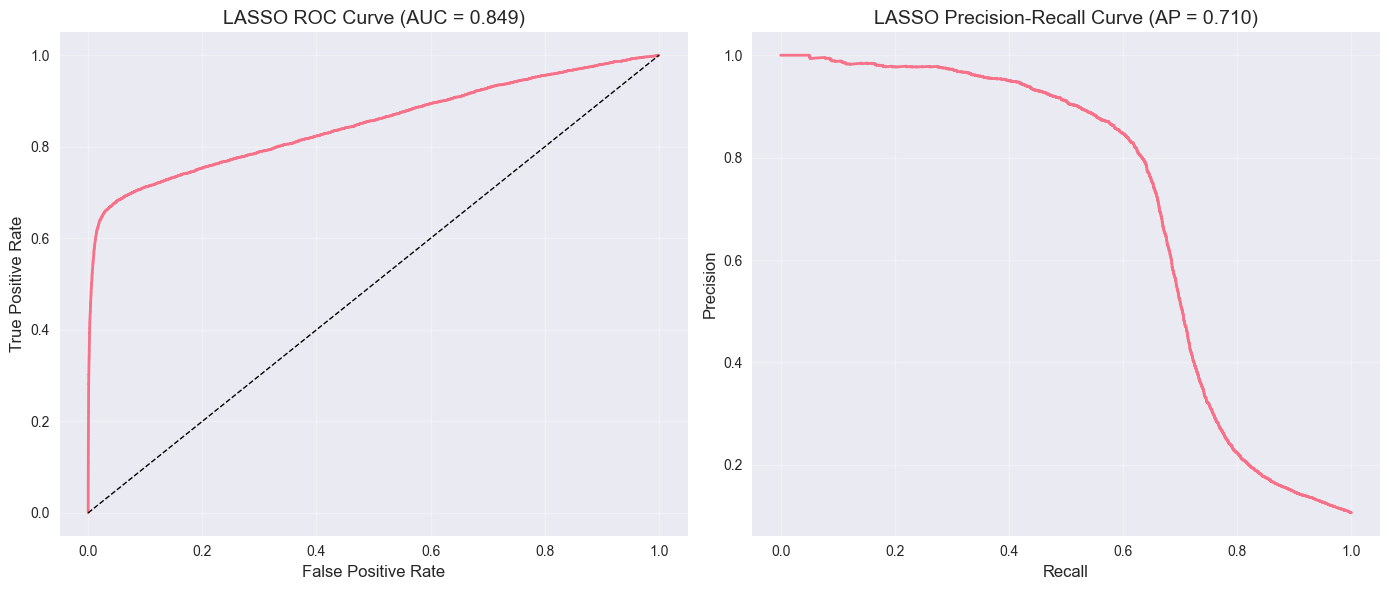


==================== Random Forest Performance ====================
AUC: 0.8531
Average Precision: 0.7002

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.96      0.96     49156
           1       0.68      0.66      0.67      5854

    accuracy                           0.93     55010
   macro avg       0.82      0.81      0.82     55010
weighted avg       0.93      0.93      0.93     55010


Confusion Matrix:
[[47361  1795]
 [ 2004  3850]]


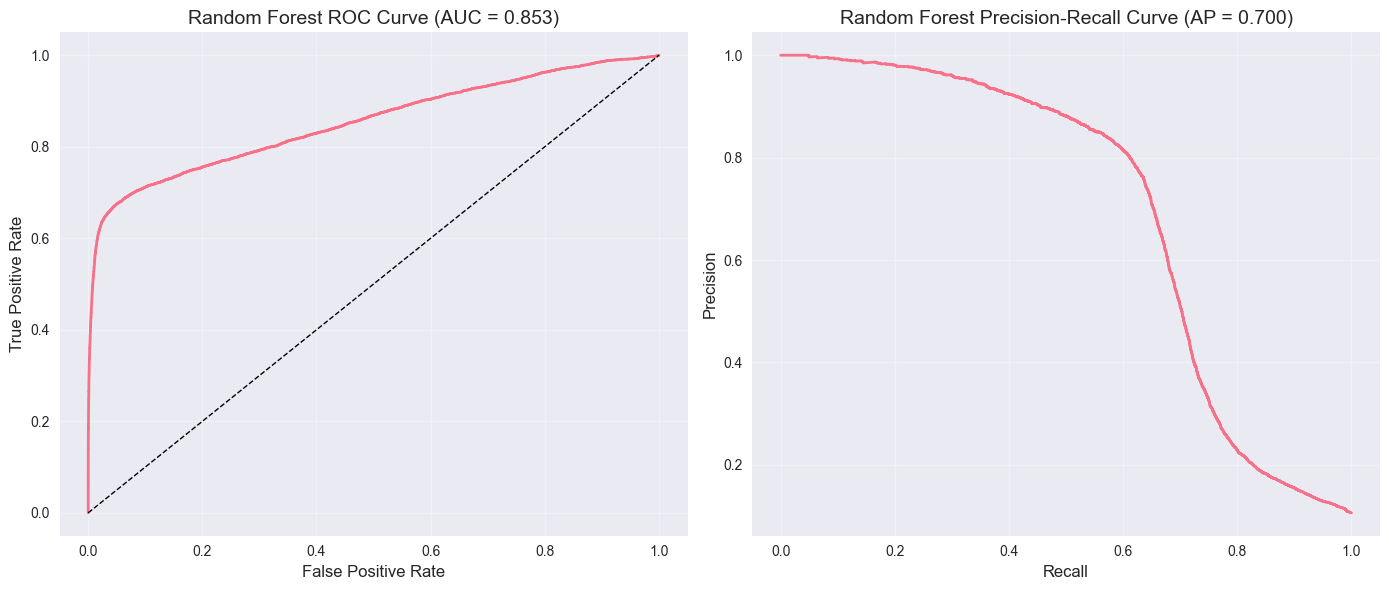

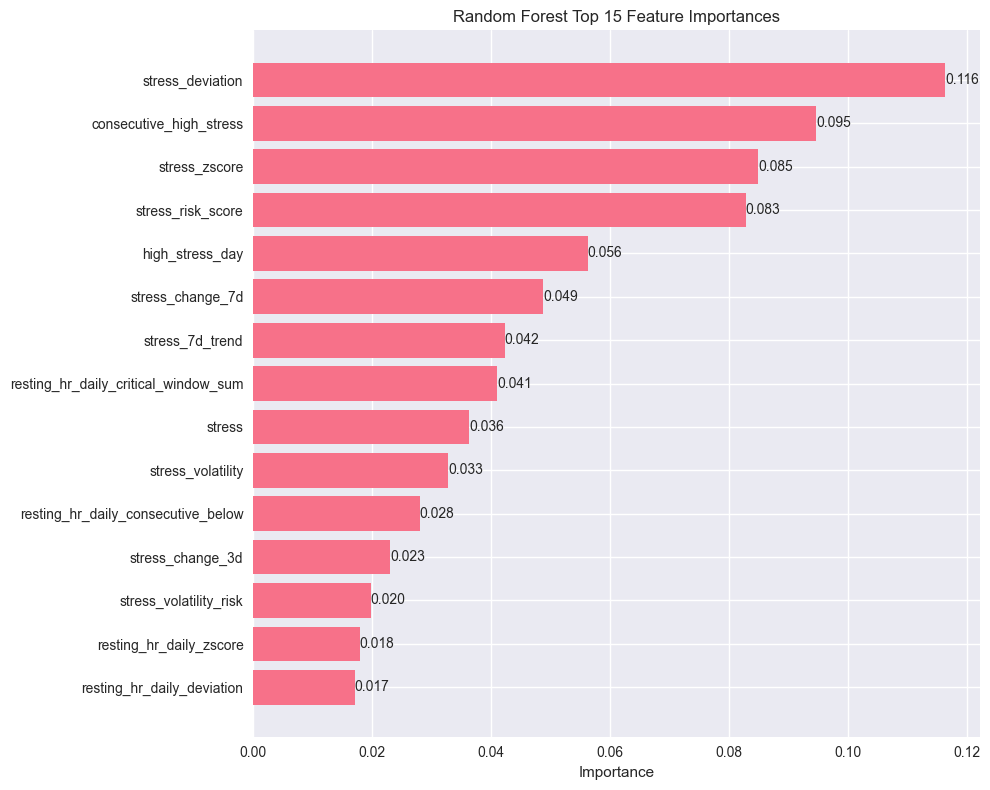


==================== XGBoost Performance ====================
AUC: 0.8524
Average Precision: 0.7093

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.95      0.95     49156
           1       0.60      0.69      0.64      5854

    accuracy                           0.92     55010
   macro avg       0.78      0.82      0.80     55010
weighted avg       0.92      0.92      0.92     55010


Confusion Matrix:
[[46479  2677]
 [ 1815  4039]]


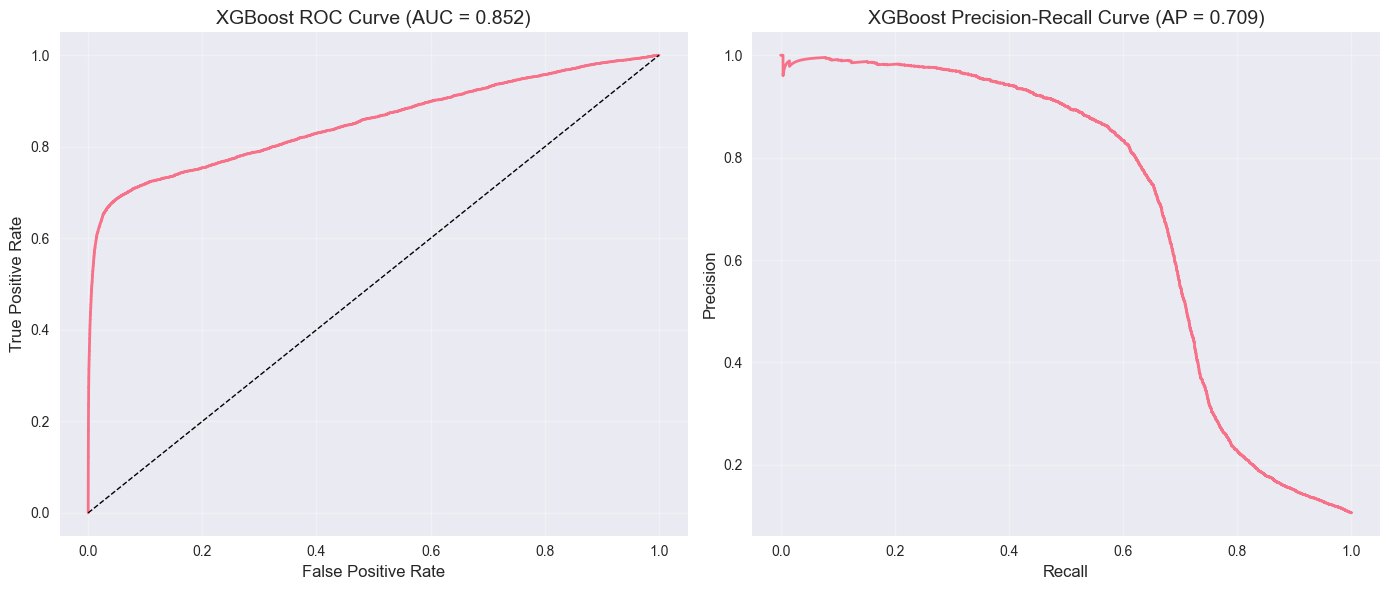

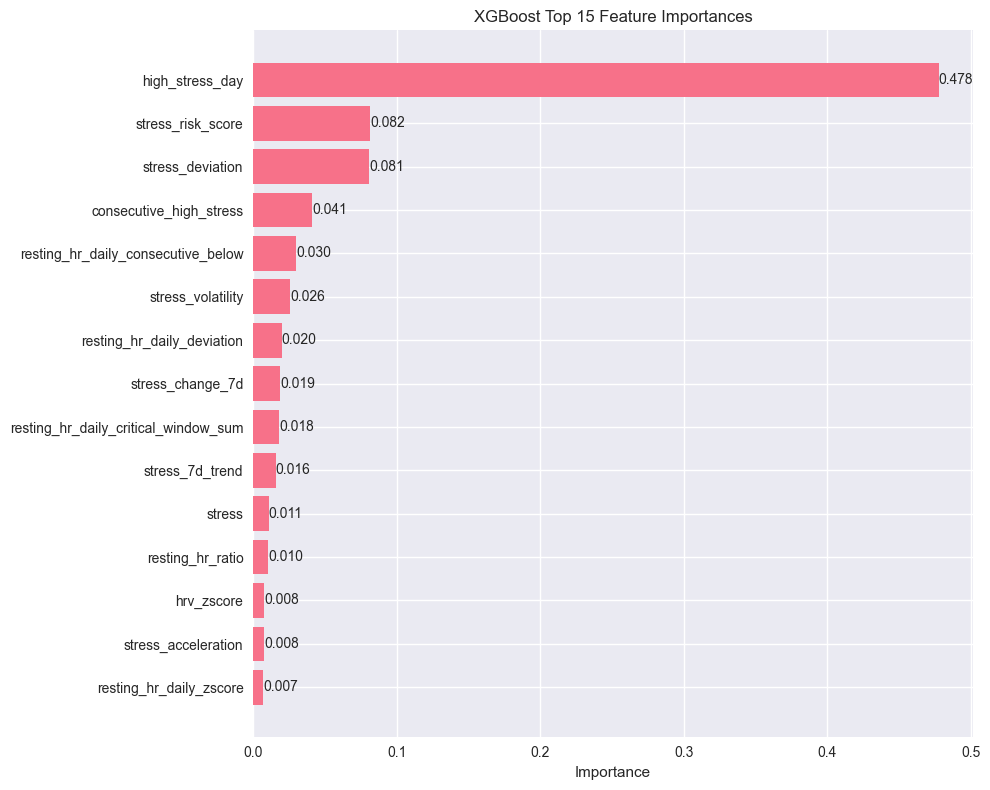

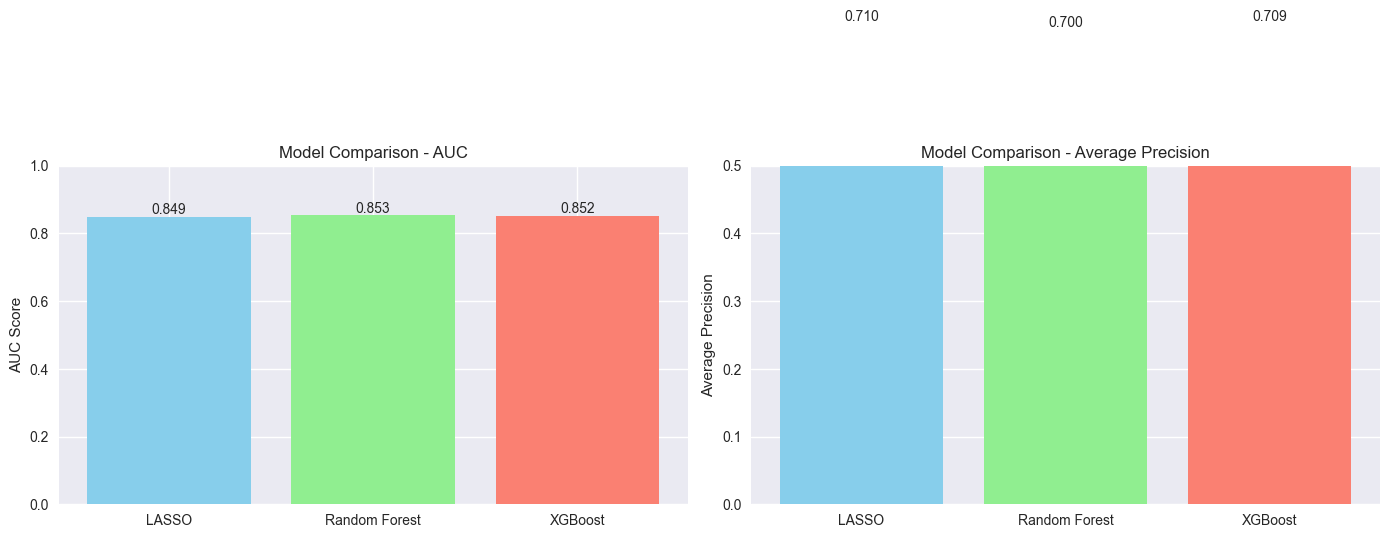


TIME-BASED SPLIT ANALYSIS
Class distribution in training set (time_based split):
0    0.887344
1    0.112656
Name: proportion, dtype: float64
Number of features: 231
Training samples: 229913
Test samples: 45614

==================== LASSO Performance ====================
AUC: 0.8550
Average Precision: 0.7251

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.92      0.94     40443
           1       0.54      0.72      0.62      5171

    accuracy                           0.90     45614
   macro avg       0.75      0.82      0.78     45614
weighted avg       0.91      0.90      0.90     45614


Confusion Matrix:
[[37271  3172]
 [ 1451  3720]]


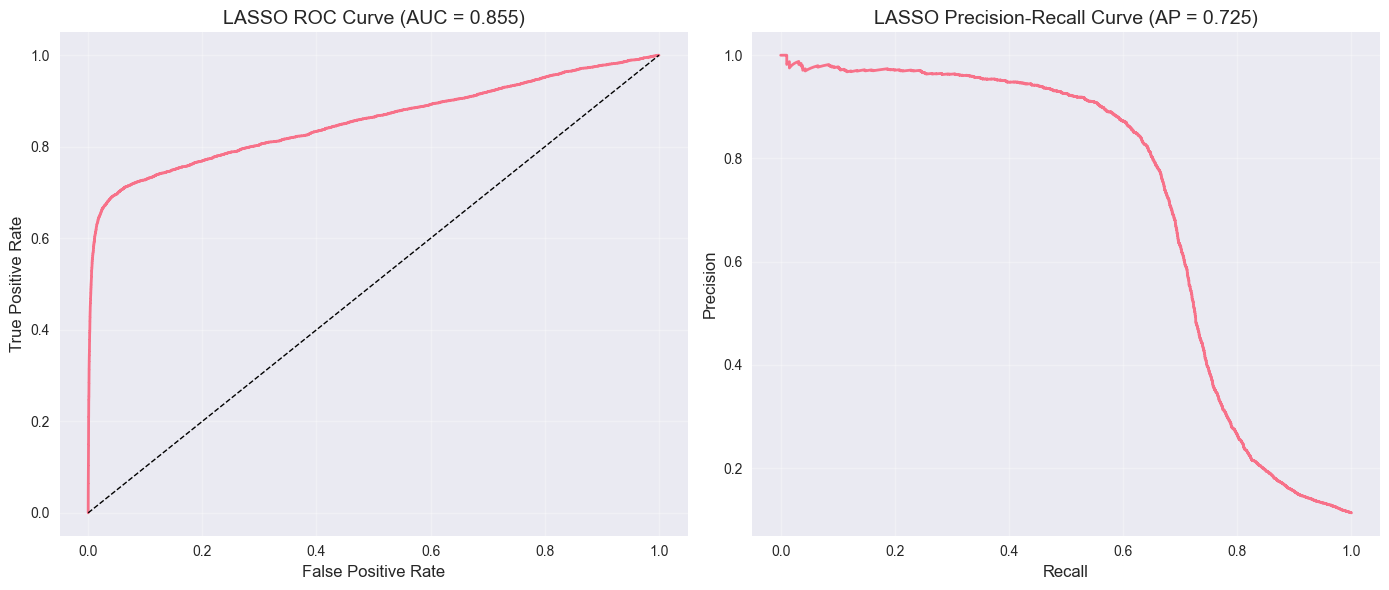


==================== Random Forest Performance ====================
AUC: 0.8552
Average Precision: 0.7177

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.96      0.96     40443
           1       0.71      0.68      0.70      5171

    accuracy                           0.93     45614
   macro avg       0.83      0.82      0.83     45614
weighted avg       0.93      0.93      0.93     45614


Confusion Matrix:
[[38972  1471]
 [ 1630  3541]]


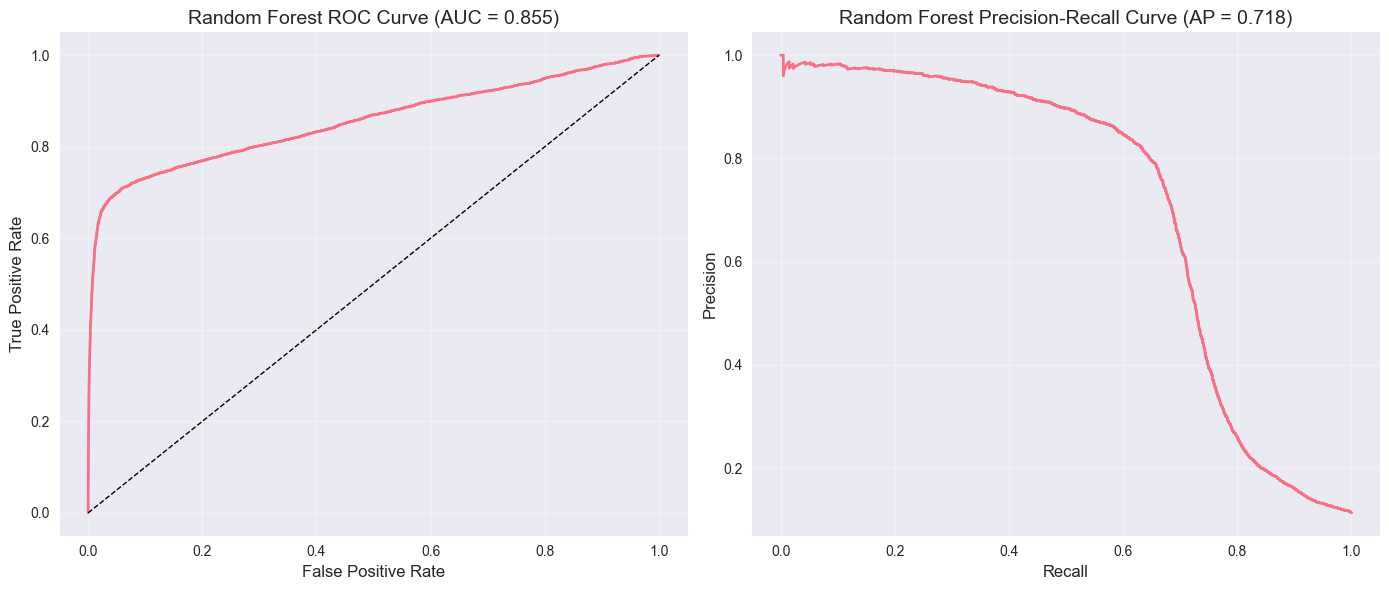

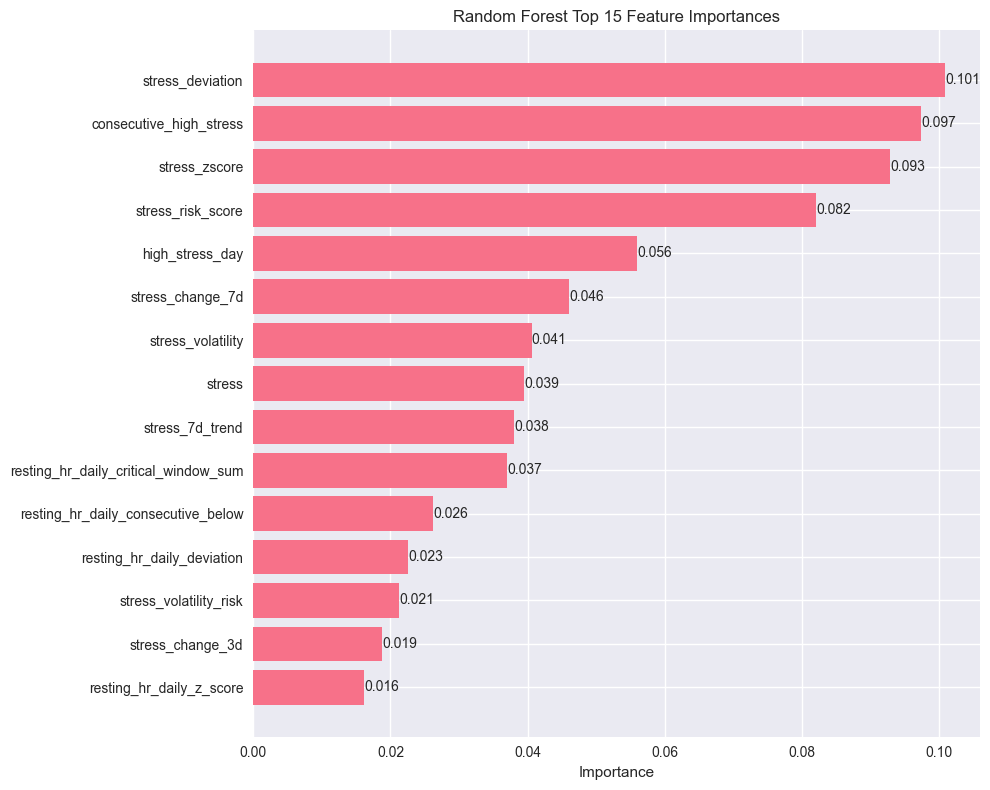


==================== XGBoost Performance ====================
AUC: 0.8580
Average Precision: 0.7264

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.95      0.95     40443
           1       0.63      0.71      0.67      5171

    accuracy                           0.92     45614
   macro avg       0.79      0.83      0.81     45614
weighted avg       0.92      0.92      0.92     45614


Confusion Matrix:
[[38265  2178]
 [ 1499  3672]]


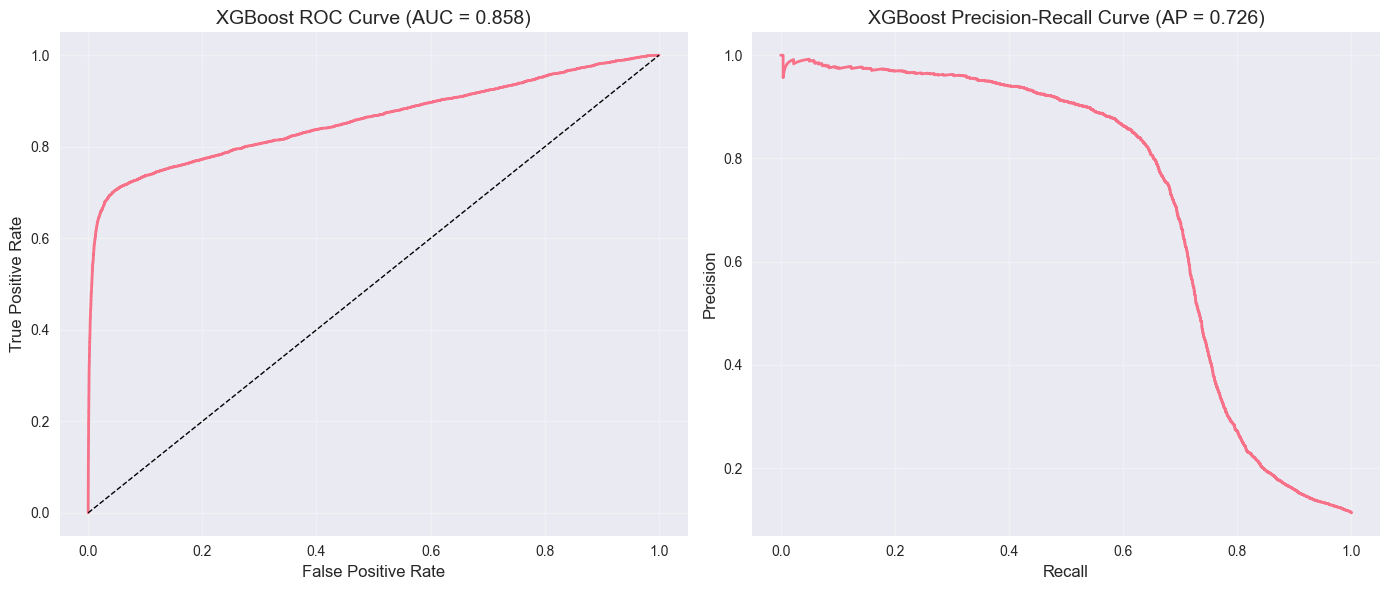

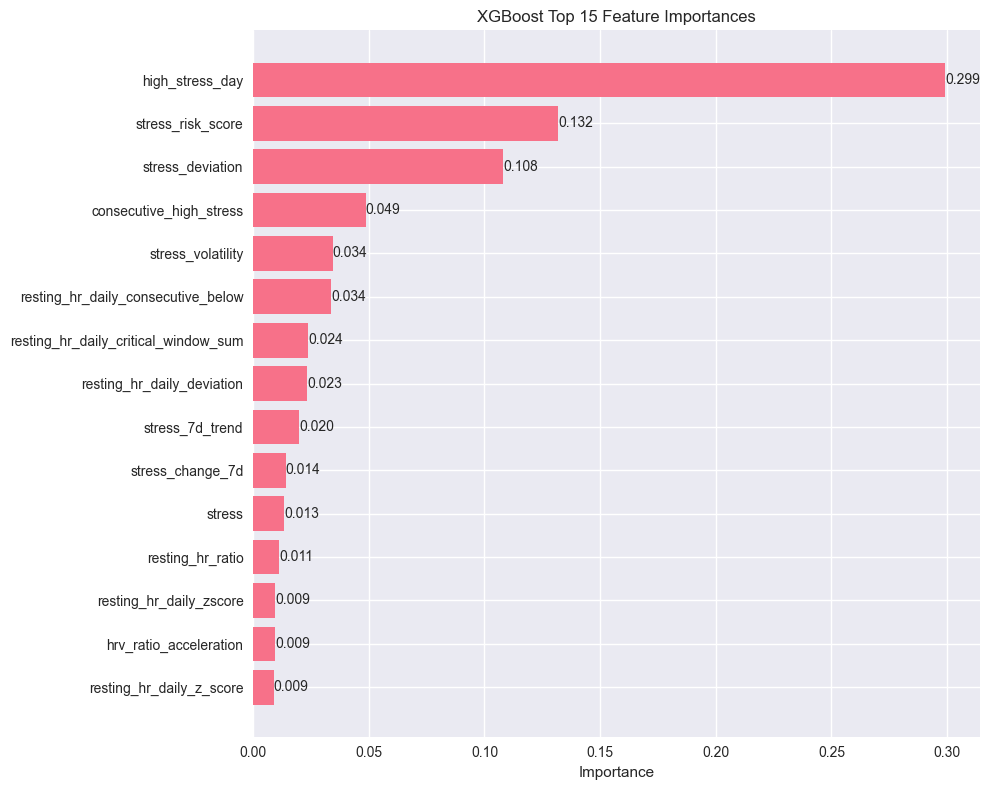

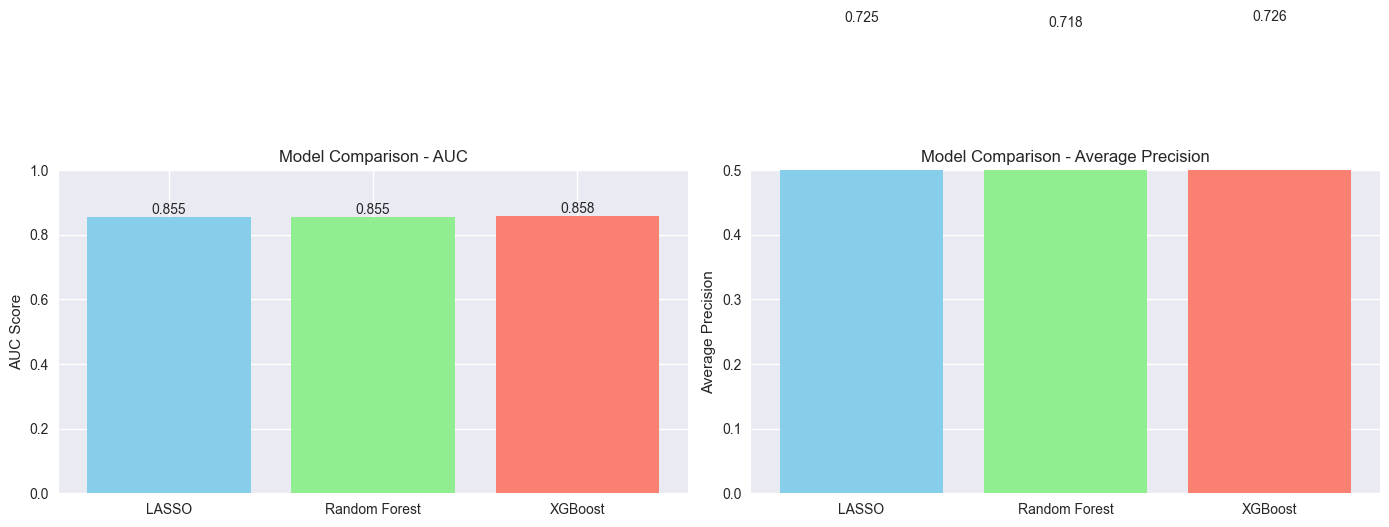

In [5]:
# Run analysis for athlete-based split
print("="*50)
print("ATHLETE-BASED SPLIT ANALYSIS")
print("="*50)
X_train_athlete, X_test_athlete, y_train_athlete, y_test_athlete = prepare_data('athlete_based')
results_athlete = train_and_evaluate_all_models(X_train_athlete, X_test_athlete, 
                                              y_train_athlete, y_test_athlete)
compare_models(results_athlete)

# Run analysis for time-based split
print("\n" + "="*50)
print("TIME-BASED SPLIT ANALYSIS")
print("="*50)
X_train_time, X_test_time, y_train_time, y_test_time = prepare_data('time_based')
results_time = train_and_evaluate_all_models(X_train_time, X_test_time, 
                                           y_train_time, y_test_time)
compare_models(results_time)

## 5. Compare Split Strategies

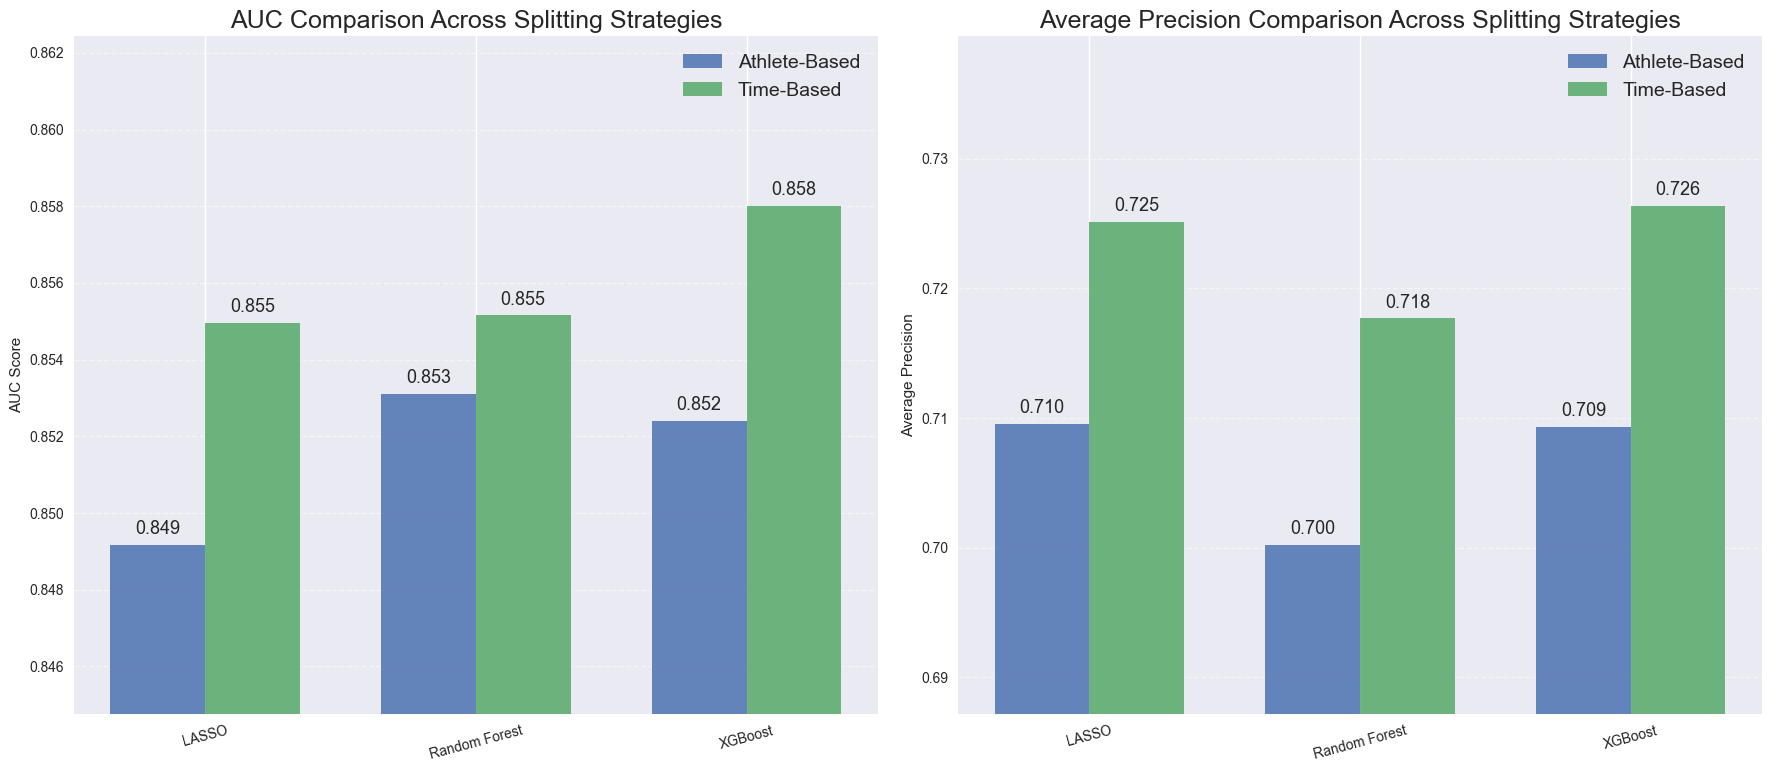

In [14]:
def compare_split_strategies(results_athlete, results_time):
    """Compare model performance across athlete-based and time-based split strategies."""
    models = list(results_athlete.keys())
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))
    
    x = np.arange(len(models))
    width = 0.35
    
    # Set consistent style
    plt.rcParams.update({
        'font.size': 16,
        'axes.titlesize': 18,
        'axes.labelsize': 16,
        'xtick.labelsize': 14,
        'ytick.labelsize': 14,
        'legend.fontsize': 14
    })
    
    # AUC comparison
    athlete_aucs = [results_athlete[model]['auc'] for model in models]
    time_aucs = [results_time[model]['auc'] for model in models]
    
    bars1_athlete = ax1.bar(x - width/2, athlete_aucs, width, label='Athlete-Based', color='#4C72B0', alpha=0.85)
    bars1_time = ax1.bar(x + width/2, time_aucs, width, label='Time-Based', color='#55A868', alpha=0.85)
    
    ax1.set_ylabel('AUC Score')
    ax1.set_title('AUC Comparison Across Splitting Strategies')
    ax1.set_xticks(x)
    ax1.set_xticklabels(models, rotation=15)
    ax1.legend()
    
    # Dynamically adjust AUC y-axis
    all_aucs = athlete_aucs + time_aucs
    min_auc = min(all_aucs)
    max_auc = max(all_aucs)
    auc_range = max_auc - min_auc
    if auc_range > 0:
        ax1.set_ylim(max(0, min_auc - auc_range * 0.5), min(1, max_auc + auc_range * 0.5))
    else:
        ax1.set_ylim(max(0, min_auc * 0.95), min(1, max_auc * 1.05))
    
    # Add AUC value labels
    for bars, values in [(bars1_athlete, athlete_aucs), (bars1_time, time_aucs)]:
        for bar, value in zip(bars, values):
            height = bar.get_height()
            ax1.annotate(f'{height:.3f}',
                         xy=(bar.get_x() + bar.get_width() / 2, height),
                         xytext=(0, 5),  # Offset text slightly above bar
                         textcoords="offset points",
                         ha='center', va='bottom', fontsize=13)
    
    ax1.grid(axis='y', linestyle='--', alpha=0.5)
    
    # Average Precision comparison
    athlete_aps = [results_athlete[model]['avg_precision'] for model in models]
    time_aps = [results_time[model]['avg_precision'] for model in models]
    
    bars2_athlete = ax2.bar(x - width/2, athlete_aps, width, label='Athlete-Based', color='#4C72B0', alpha=0.85)
    bars2_time = ax2.bar(x + width/2, time_aps, width, label='Time-Based', color='#55A868', alpha=0.85)
    
    ax2.set_ylabel('Average Precision')
    ax2.set_title('Average Precision Comparison Across Splitting Strategies')
    ax2.set_xticks(x)
    ax2.set_xticklabels(models, rotation=15)
    ax2.legend()
    
    # Dynamically adjust AP y-axis
    all_aps = athlete_aps + time_aps
    min_ap = min(all_aps)
    max_ap = max(all_aps)
    ap_range = max_ap - min_ap
    if ap_range > 0:
        ax2.set_ylim(max(0, min_ap - ap_range * 0.5), min(1, max_ap + ap_range * 0.5))
    else:
        ax2.set_ylim(max(0, min_ap * 0.95), min(1, max_ap * 1.05))
    
    # Add AP value labels
    for bars, values in [(bars2_athlete, athlete_aps), (bars2_time, time_aps)]:
        for bar, value in zip(bars, values):
            height = bar.get_height()
            ax2.annotate(f'{height:.3f}',
                         xy=(bar.get_x() + bar.get_width() / 2, height),
                         xytext=(0, 5),
                         textcoords="offset points",
                         ha='center', va='bottom', fontsize=13)
    
    ax2.grid(axis='y', linestyle='--', alpha=0.5)
    
    plt.tight_layout()
    plt.show()

# Execute comparison
compare_split_strategies(results_athlete, results_time)

## 6. Feature Importance Analysis Across Models

LASSO Feature Importances - Athlete Split:
                       Feature  Importance
9                    rem_sleep   13.154960
147       deep_sleep_deviation   11.230501
84            resting_hr_ratio    9.286706
146        deep_sleep_baseline    8.930160
131        hrv_ratio_change_1d    8.056130
7                   deep_sleep    6.338029
155         rem_sleep_baseline    6.094137
156        rem_sleep_deviation    6.002428
81                hrv_7d_slope    4.710333
78                   hrv_ratio    3.133805
133     hrv_ratio_acceleration    2.434921
8                  light_sleep    2.395003
138                  hrv_cv_7d    2.211054
139          sleep_hours_cv_7d    2.195390
44   strength_intensity_factor    1.701358

LASSO Feature Importances - Time Split:
                           Feature  Importance
9                        rem_sleep   14.969906
147           deep_sleep_deviation   11.306842
84                resting_hr_ratio    8.956568
146            deep_sleep_baseline    8.

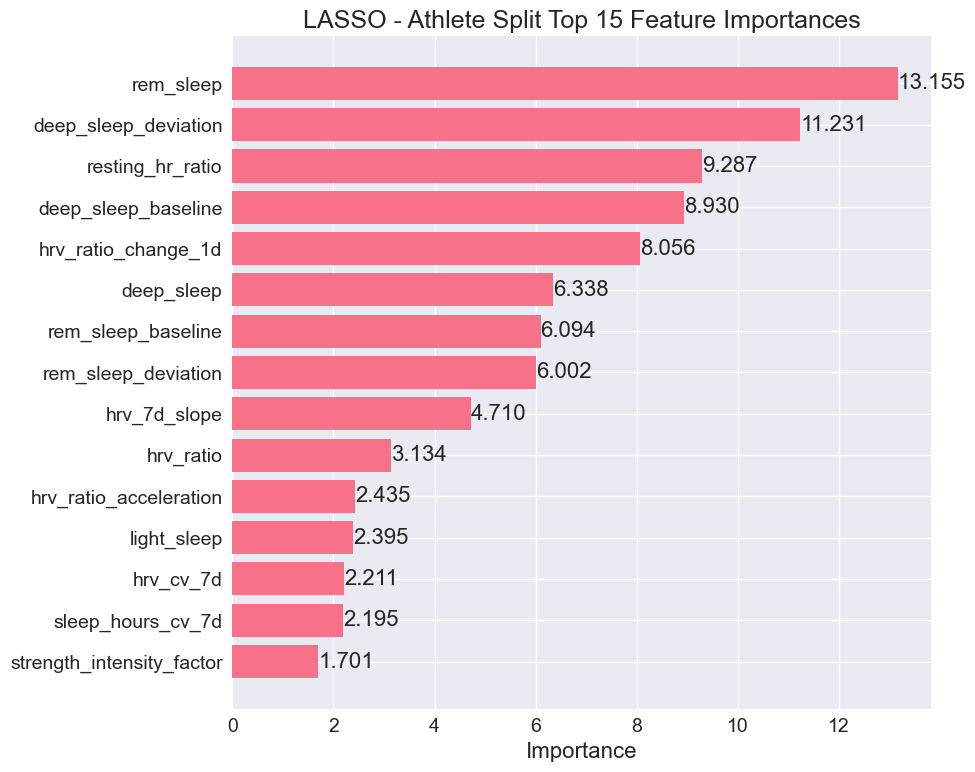

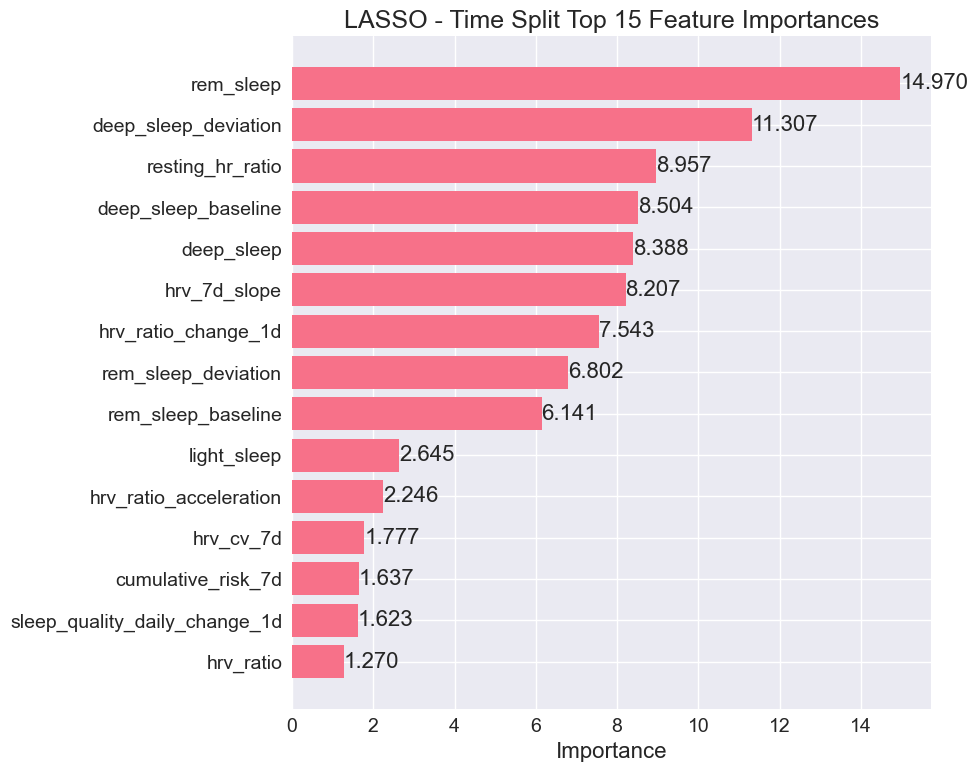

In [22]:
lasso_model_athlete = results_athlete['LASSO']['model']
lasso_model_time = results_time['LASSO']['model']
lasso_athlete_coefficients = lasso_model_athlete.coef_[0]
lasso_time_coefficients = lasso_model_time.coef_[0]

# Create a DataFrame with feature names and their coefficients
lasso_importances_athlete = pd.DataFrame({
    'Feature': X_train_athlete.columns,  # Make sure you have X_train available
    'Importance': np.abs(lasso_athlete_coefficients)  # Using absolute values for importance
}).sort_values('Importance', ascending=False)

lasso_importances_time = pd.DataFrame({
    'Feature': X_train_time.columns,  # Make sure you have X_train available
    'Importance': np.abs(lasso_time_coefficients)  # Using absolute values for importance
}).sort_values('Importance', ascending=False)

print("LASSO Feature Importances - Athlete Split:")
print(lasso_importances_athlete.head(15))

print("\nLASSO Feature Importances - Time Split:")
print(lasso_importances_time.head(15))
# Plot LASSO feature importances
plot_feature_importance(lasso_importances_athlete, "LASSO - Athlete Split", top_n=15)
plot_feature_importance(lasso_importances_time, "LASSO - Time Split", top_n=15)

# For athlete split
lasso_model_athlete = results_athlete['LASSO']['model']
lasso_coefficients_athlete = lasso_model_athlete.coef_[0]
lasso_importances_athlete = pd.DataFrame({
    'Feature': X_train_athlete.columns,  # Use the appropriate X_train for athlete split
    'Importance': np.abs(lasso_coefficients_athlete)
}).sort_values('Importance', ascending=False)
results_athlete['LASSO']['feature_importance'] = lasso_importances_athlete

# For time split
lasso_model_time = results_time['LASSO']['model']
lasso_coefficients_time = lasso_model_time.coef_[0]
lasso_importances_time = pd.DataFrame({
    'Feature': X_train_time.columns,  # Use the appropriate X_train for time split
    'Importance': np.abs(lasso_coefficients_time)
}).sort_values('Importance', ascending=False)
results_time['LASSO']['feature_importance'] = lasso_importances_time

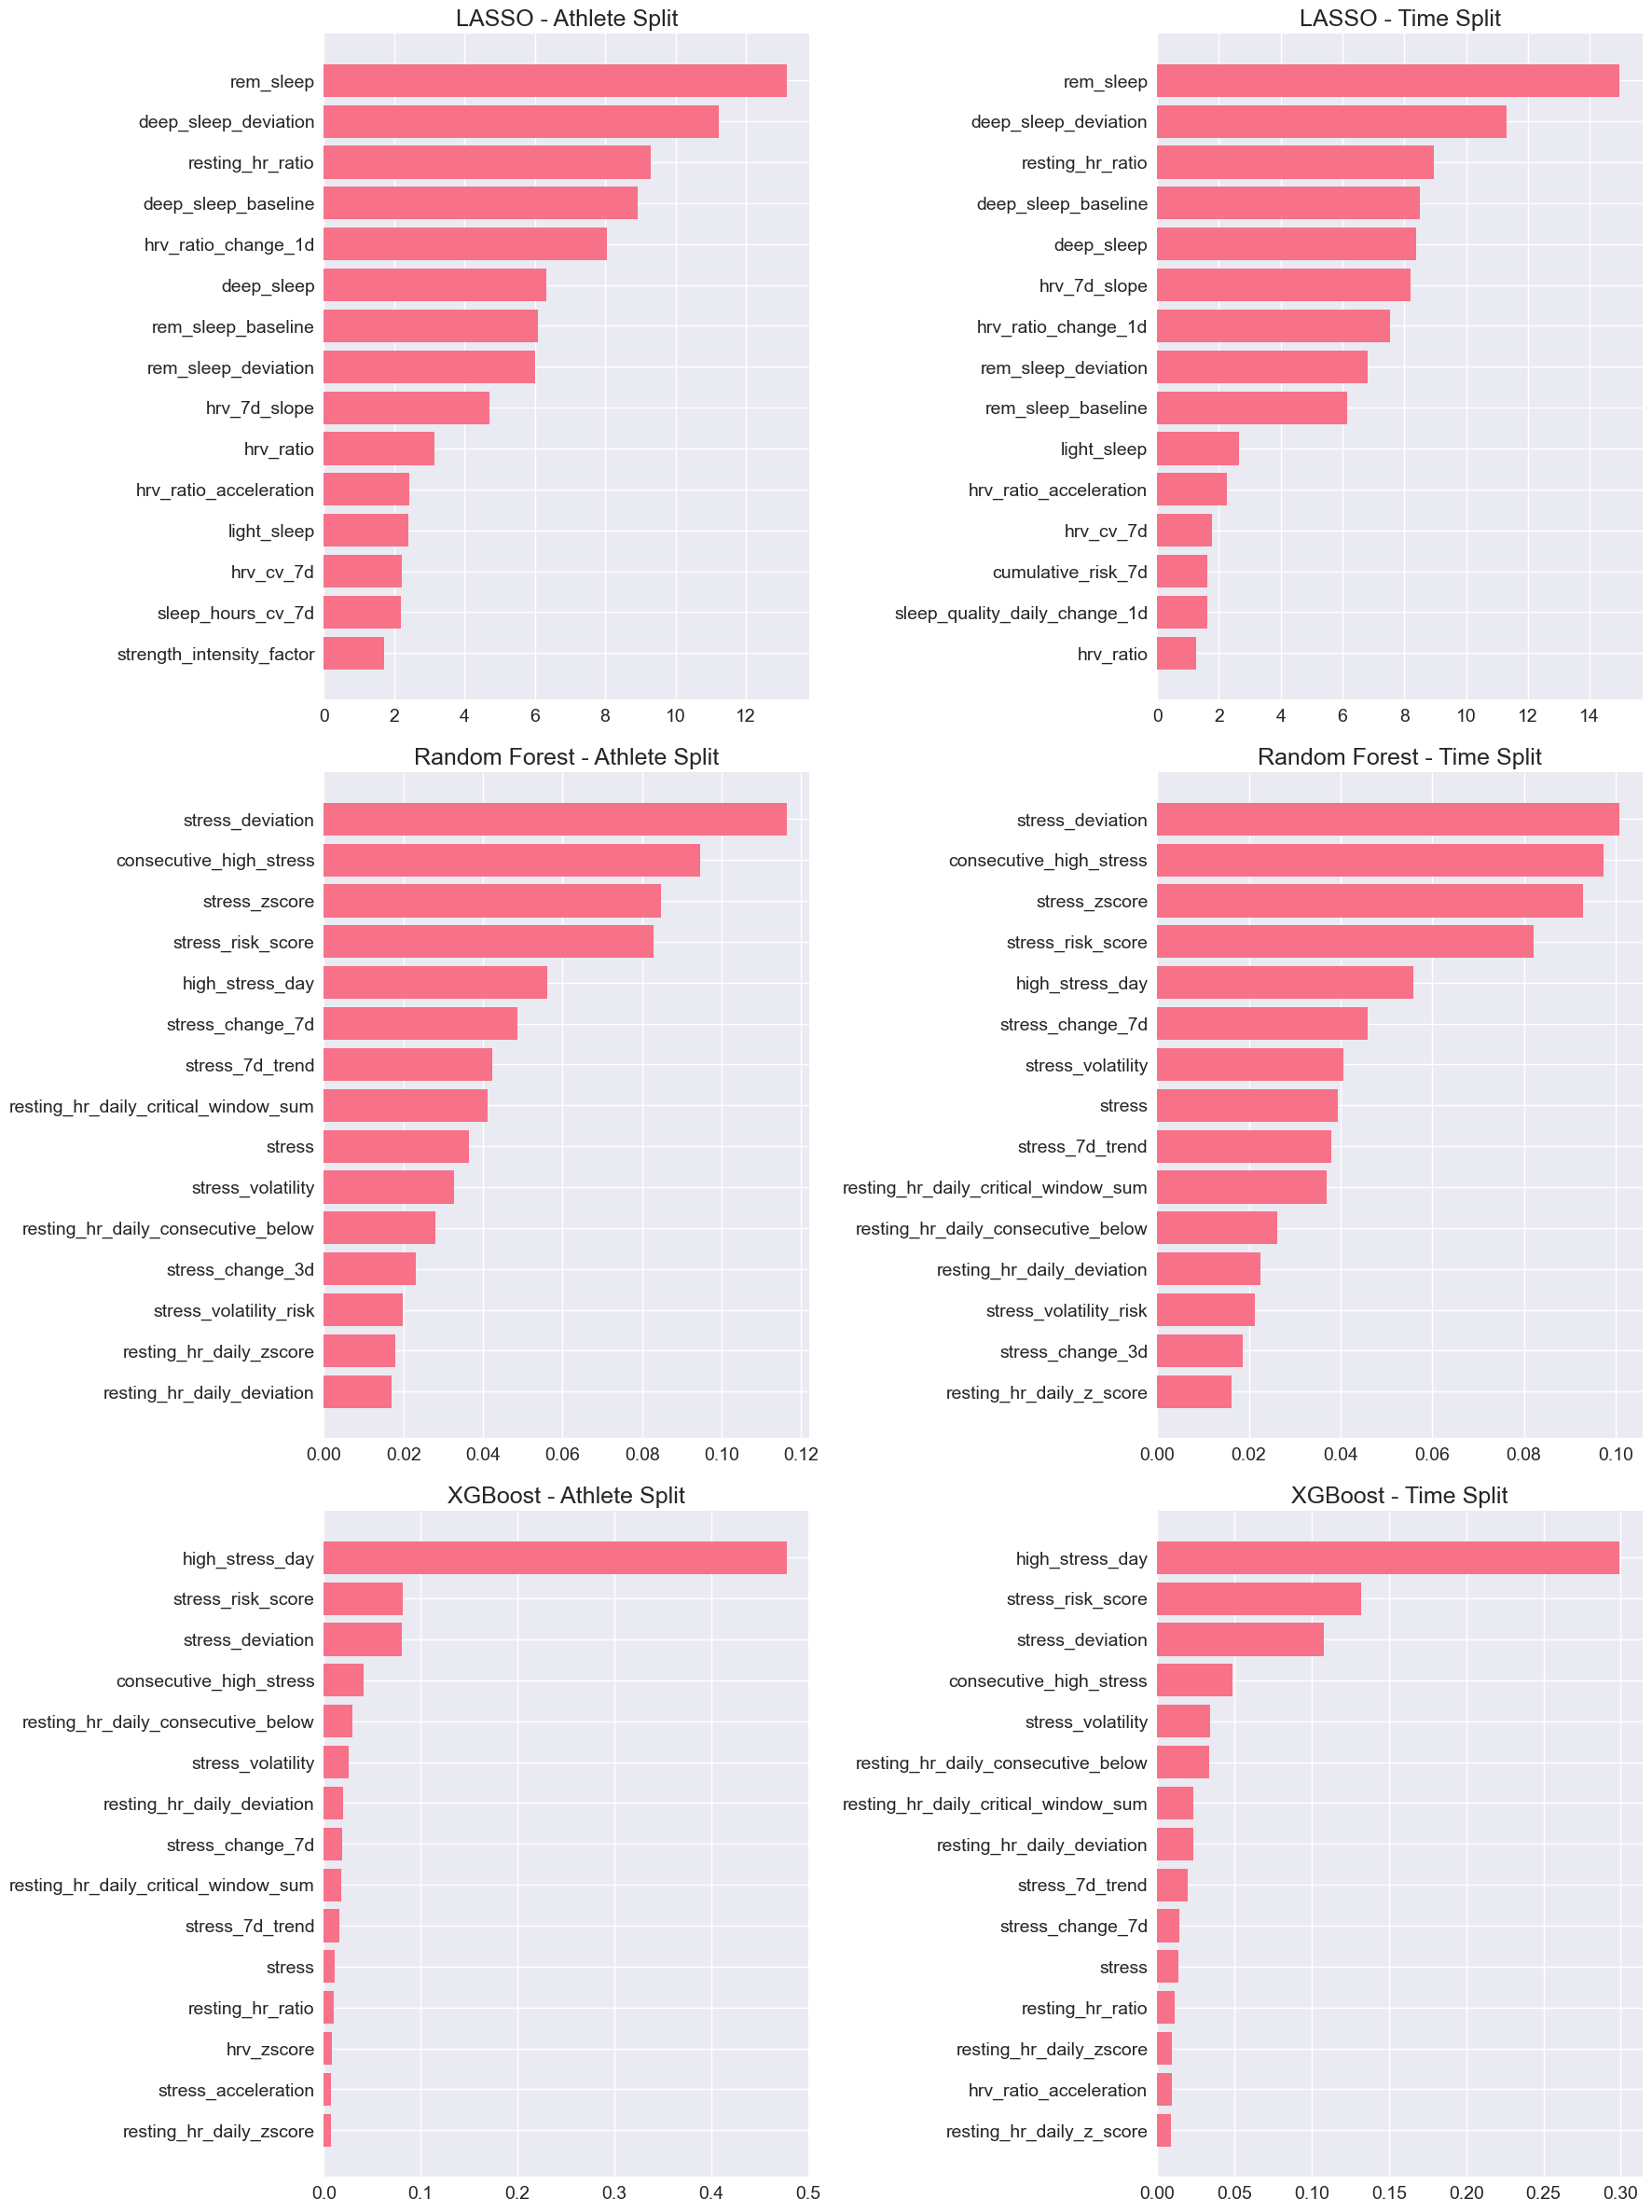

In [23]:
# Compare feature importance
def compare_feature_importance(results_athlete, results_time, top_n=15):
    """Compare top features across models and splits."""
    fig, axes = plt.subplots(3, 2, figsize=(18, 24))  # Changed to 3x2 for LASSO
    
    # LASSO - Athlete split
    lasso_athlete_imp = results_athlete['LASSO']['feature_importance'].head(top_n)
    axes[0, 0].barh(range(top_n), lasso_athlete_imp['Importance'])
    axes[0, 0].set_yticks(range(top_n))
    axes[0, 0].set_yticklabels(lasso_athlete_imp['Feature'])
    axes[0, 0].set_title('LASSO - Athlete Split')
    axes[0, 0].invert_yaxis()
    
    # LASSO - Time split
    lasso_time_imp = results_time['LASSO']['feature_importance'].head(top_n)
    axes[0, 1].barh(range(top_n), lasso_time_imp['Importance'])
    axes[0, 1].set_yticks(range(top_n))
    axes[0, 1].set_yticklabels(lasso_time_imp['Feature'])
    axes[0, 1].set_title('LASSO - Time Split')
    axes[0, 1].invert_yaxis()
    
    # Random Forest - Athlete split
    rf_athlete_imp = results_athlete['Random Forest']['feature_importance'].head(top_n)
    axes[1, 0].barh(range(top_n), rf_athlete_imp['Importance'])
    axes[1, 0].set_yticks(range(top_n))
    axes[1, 0].set_yticklabels(rf_athlete_imp['Feature'])
    axes[1, 0].set_title('Random Forest - Athlete Split')
    axes[1, 0].invert_yaxis()
    
    # Random Forest - Time split
    rf_time_imp = results_time['Random Forest']['feature_importance'].head(top_n)
    axes[1, 1].barh(range(top_n), rf_time_imp['Importance'])
    axes[1, 1].set_yticks(range(top_n))
    axes[1, 1].set_yticklabels(rf_time_imp['Feature'])
    axes[1, 1].set_title('Random Forest - Time Split')
    axes[1, 1].invert_yaxis()
    
    # XGBoost - Athlete split
    xgb_athlete_imp = results_athlete['XGBoost']['feature_importance'].head(top_n)
    axes[2, 0].barh(range(top_n), xgb_athlete_imp['Importance'])
    axes[2, 0].set_yticks(range(top_n))
    axes[2, 0].set_yticklabels(xgb_athlete_imp['Feature'])
    axes[2, 0].set_title('XGBoost - Athlete Split')
    axes[2, 0].invert_yaxis()
    
    # XGBoost - Time split
    xgb_time_imp = results_time['XGBoost']['feature_importance'].head(top_n)
    axes[2, 1].barh(range(top_n), xgb_time_imp['Importance'])
    axes[2, 1].set_yticks(range(top_n))
    axes[2, 1].set_yticklabels(xgb_time_imp['Feature'])
    axes[2, 1].set_title('XGBoost - Time Split')
    axes[2, 1].invert_yaxis()
    
    plt.tight_layout()
    plt.show()

# Execute feature importance comparison
compare_feature_importance(results_athlete, results_time)

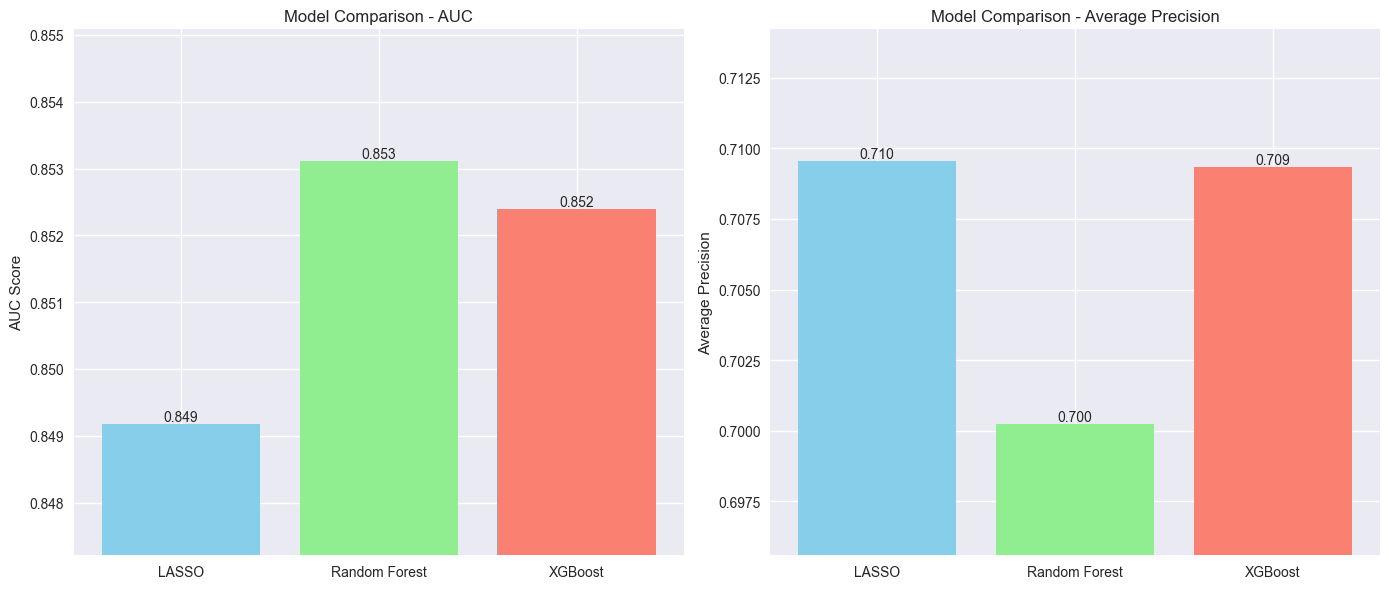

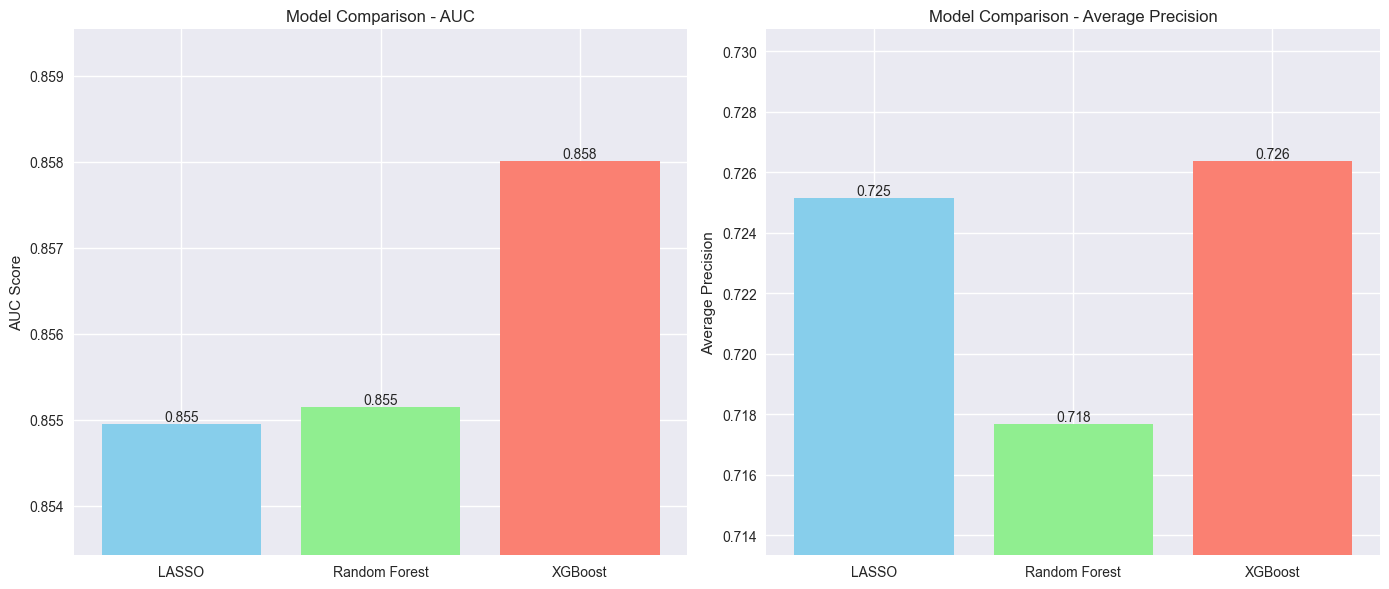

In [13]:
compare_models(results_athlete)
compare_models(results_time)


Top 3 Features Summary:
                                    Feature                             Importance           
Split                         Athlete Split               Time Split Athlete Split Time Split
Model         Rank                                                                           
LASSO         1                   Rem Sleep                Rem Sleep        13.155     14.970
              2        Deep Sleep Deviation     Deep Sleep Deviation        11.231     11.307
              3            Resting Hr Ratio         Resting Hr Ratio         9.287      8.957
Random Forest 1            Stress Deviation         Stress Deviation         0.116      0.101
              2     Consecutive High Stress  Consecutive High Stress         0.095      0.097
              3               Stress Zscore            Stress Zscore         0.085      0.093
XGBoost       1             High Stress Day          High Stress Day         0.478      0.299
              2           Stress Ri

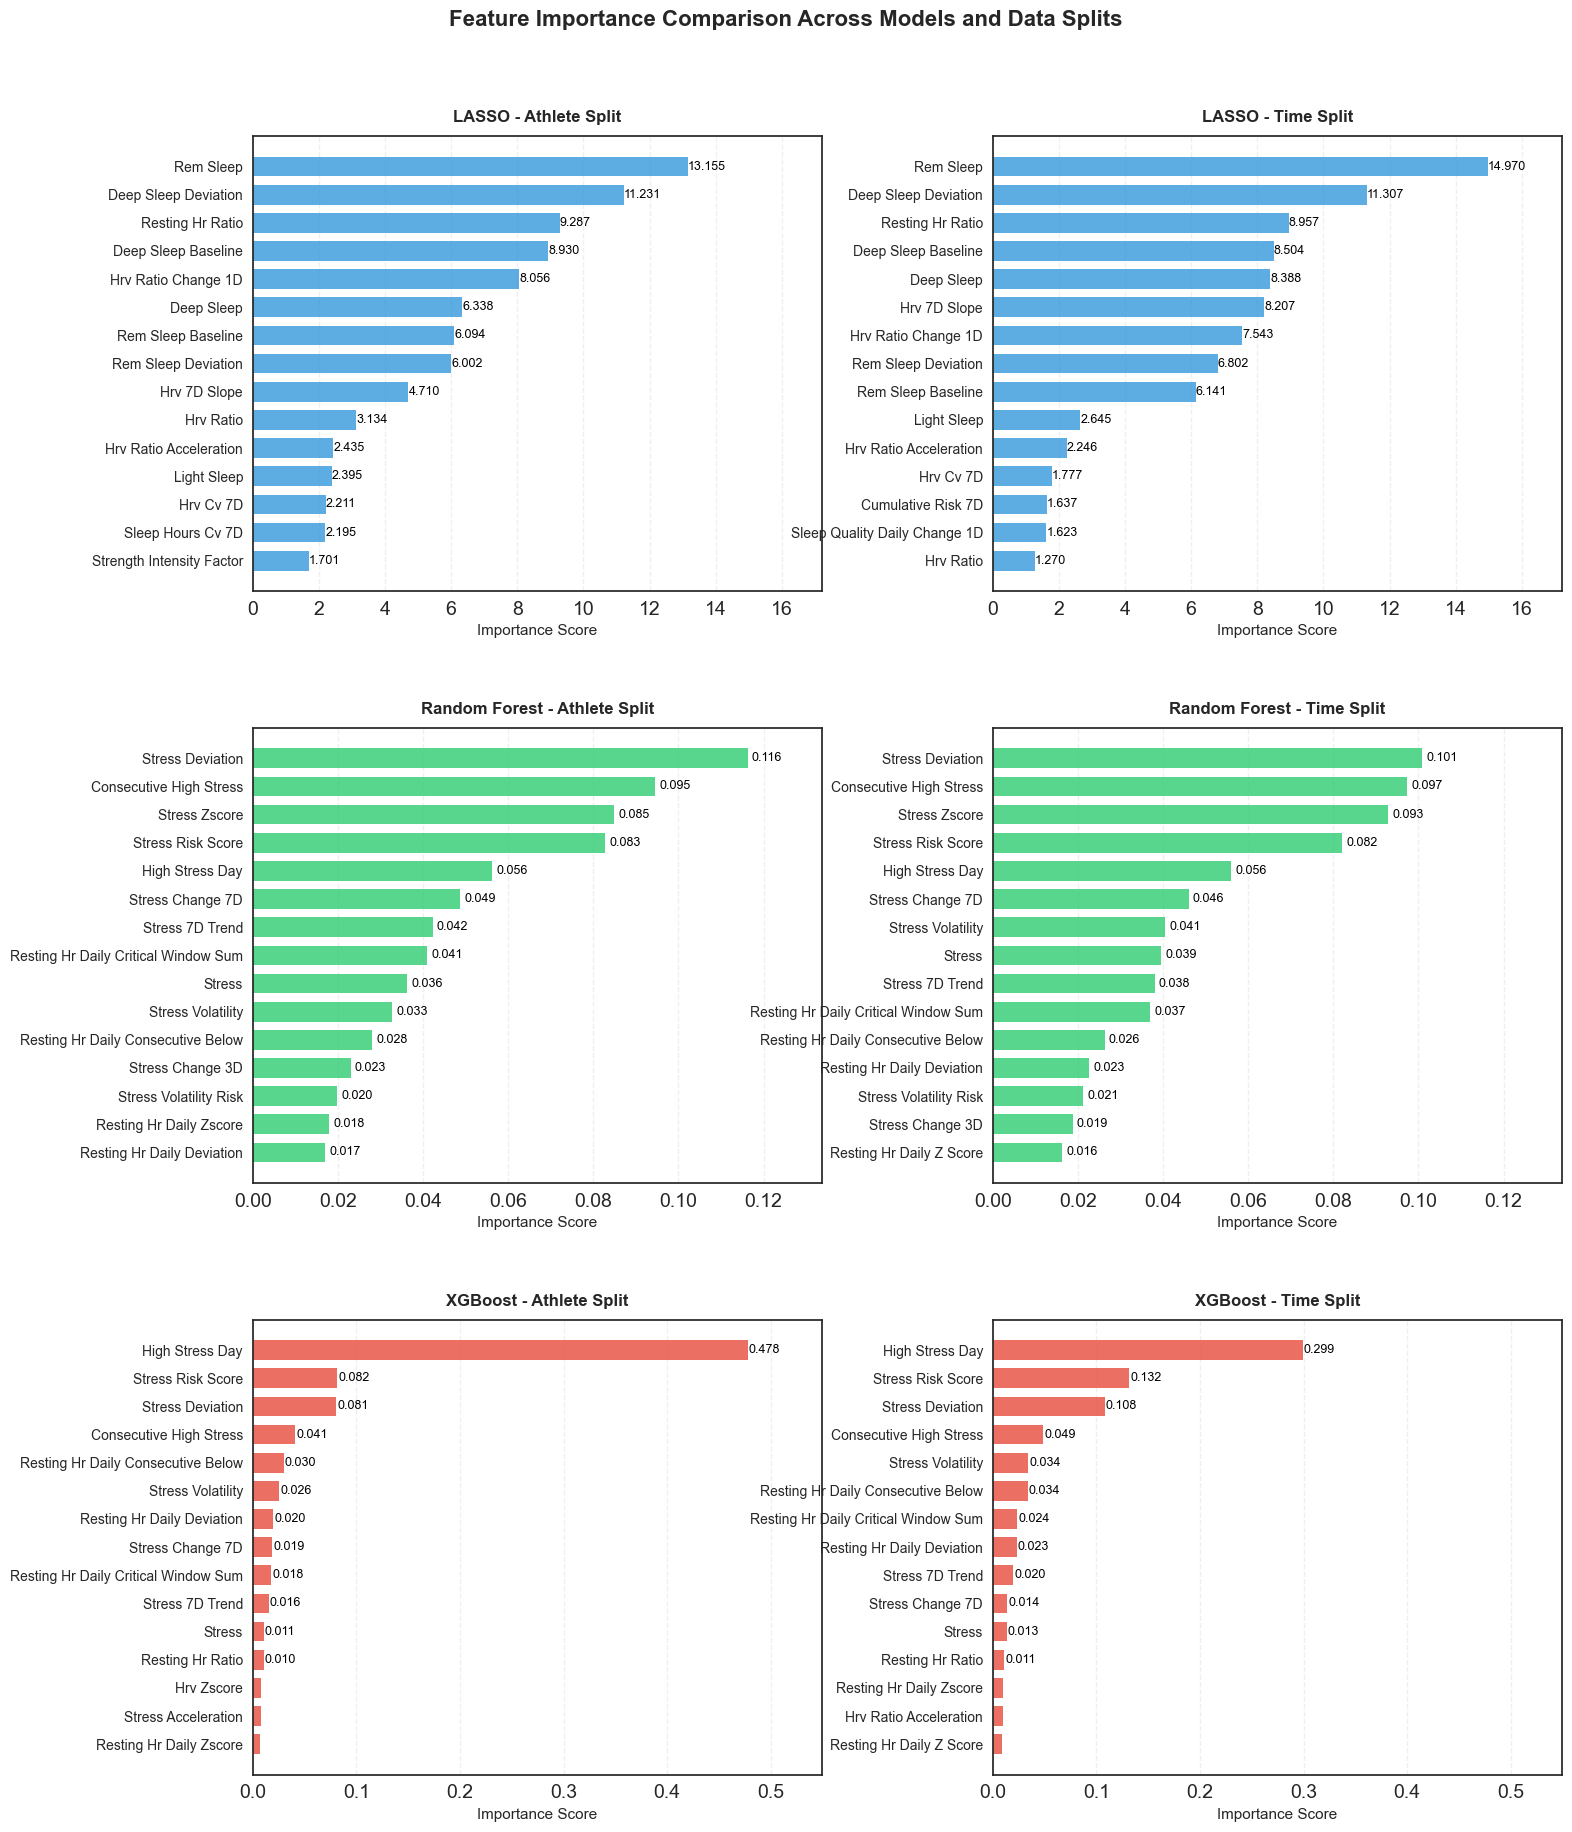

<Figure size 1400x1000 with 0 Axes>

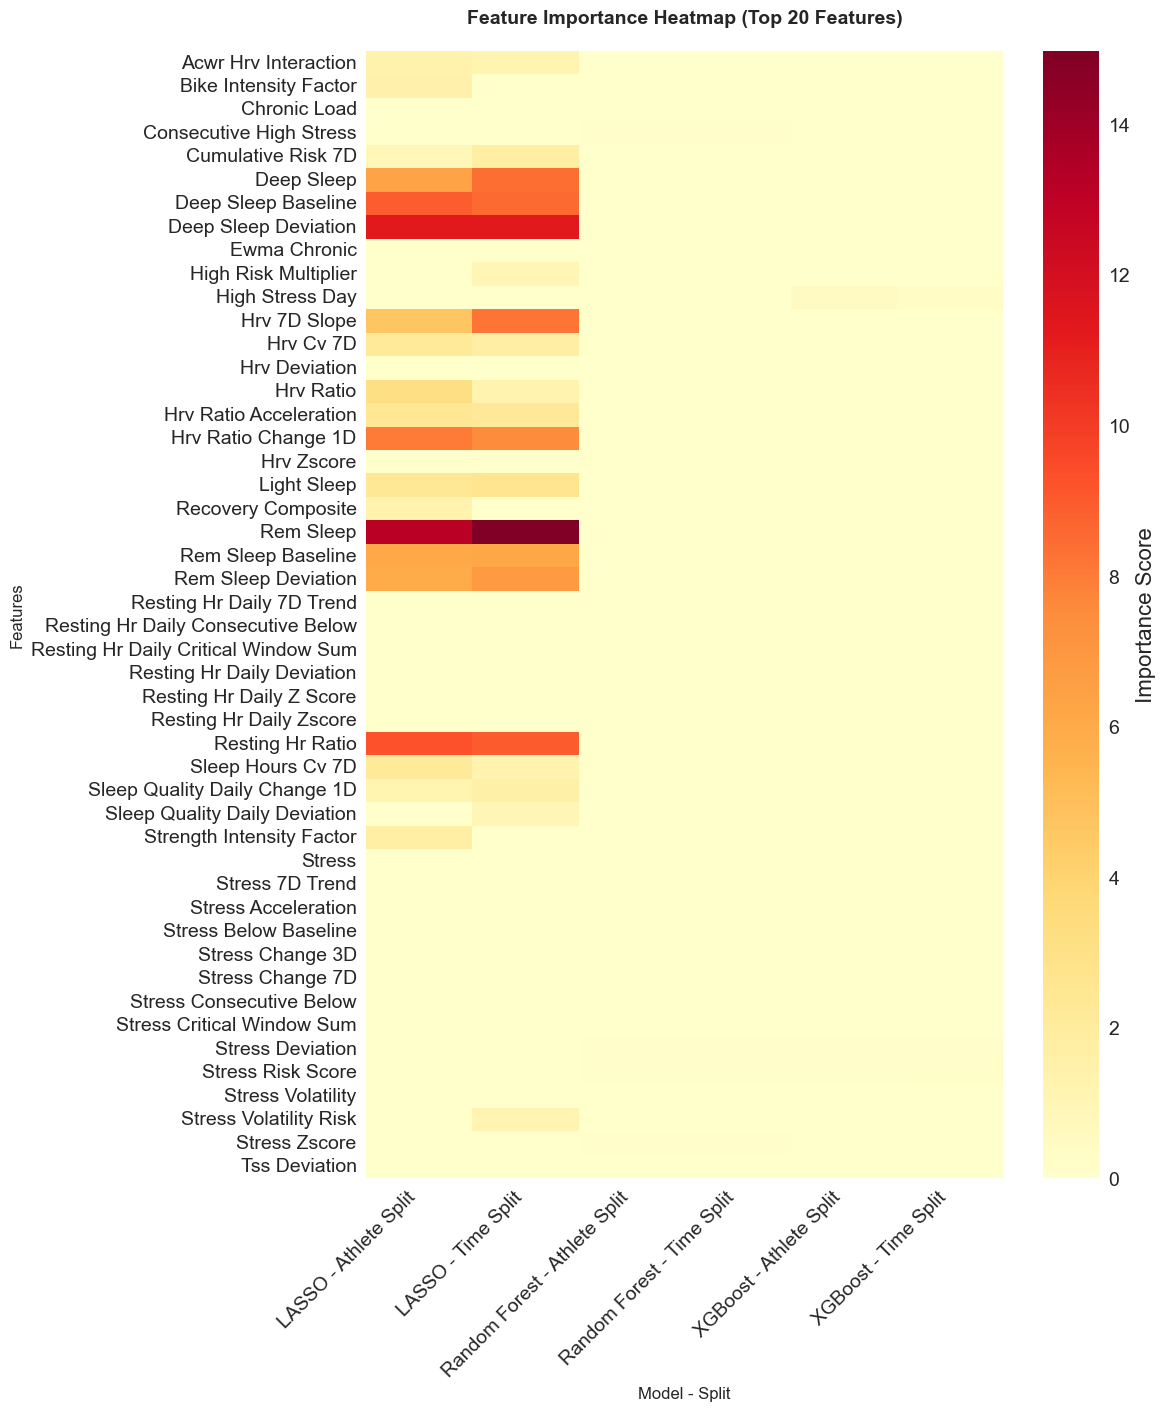

In [24]:
def compare_feature_importance_improved(results_athlete, results_time, top_n=15):
    """Compare top features across models and splits with improved visualization."""
    
    # Set a professional style
    plt.style.use('seaborn-v0_8-white')
    
    # Create figure with better spacing
    fig, axes = plt.subplots(3, 2, figsize=(16, 18))
    fig.suptitle('Feature Importance Comparison Across Models and Data Splits', 
                 fontsize=16, fontweight='bold', y=1.02)
    
    # Define consistent colors for each model
    colors = {
        'LASSO': '#3498db',    # Blue
        'Random Forest': '#2ecc71',  # Green
        'XGBoost': '#e74c3c'  # Red
    }
    
    models = ['LASSO', 'Random Forest', 'XGBoost']
    splits = ['Athlete Split', 'Time Split']
    
    for i, model in enumerate(models):
        for j, split in enumerate(splits):
            ax = axes[i, j]
            
            # Get data based on model and split
            if split == 'Athlete Split':
                importance_data = results_athlete[model]['feature_importance'].head(top_n)
            else:
                importance_data = results_time[model]['feature_importance'].head(top_n)
            
            # Create horizontal bar plot
            bars = ax.barh(range(top_n), importance_data['Importance'], 
                          color=colors[model], alpha=0.8, height=0.7)
            
            # Format feature names to be more readable
            feature_names = [name.replace('_', ' ').title() for name in importance_data['Feature']]
            
            # Set y-axis
            ax.set_yticks(range(top_n))
            ax.set_yticklabels(feature_names, fontsize=10)
            ax.invert_yaxis()
            
            # Set x-axis
            ax.set_xlabel('Importance Score', fontsize=11)
            ax.grid(axis='x', alpha=0.3, linestyle='--')
            
            # Set title
            ax.set_title(f'{model} - {split}', fontsize=12, fontweight='bold', pad=10)
            
            # Add value labels on bars for better readability
            for bar, value in zip(bars, importance_data['Importance']):
                width = bar.get_width()
                if width > 0.01:  # Only show labels for visible bars
                    ax.text(width + 0.001, bar.get_y() + bar.get_height()/2, 
                           f'{value:.3f}', va='center', fontsize=9, color='black')
            
            # Ensure consistent x-axis limits within model rows for comparison
            if j == 0:
                athlete_max = importance_data['Importance'].max()
            else:
                time_max = importance_data['Importance'].max()
                max_val = max(athlete_max, time_max) * 1.15  # Add 15% padding
                axes[i, 0].set_xlim(0, max_val)
                axes[i, 1].set_xlim(0, max_val)
    
    # Adjust layout
    plt.tight_layout()
    plt.subplots_adjust(top=0.95, hspace=0.3, wspace=0.3)
    
    # Create a summary table of top features
    top_features_summary = create_feature_summary_table(results_athlete, results_time, models, splits)
    
    # Save high-resolution version for thesis
    plt.savefig('feature_importance_comparison.png', dpi=300, bbox_inches='tight', 
                facecolor='white', edgecolor='none')
    plt.savefig('feature_importance_comparison.pdf', format='pdf', bbox_inches='tight')
    
    plt.show()
    
    return top_features_summary


def create_feature_summary_table(results_athlete, results_time, models, splits):
    """Create a summary table of top features for each model and split."""
    
    summary_data = []
    
    for model in models:
        for split in splits:
            results = results_athlete if split == 'Athlete Split' else results_time
            top_features = results[model]['feature_importance'].head(3)
            
            for rank, (_, row) in enumerate(top_features.iterrows(), 1):
                summary_data.append({
                    'Model': model,
                    'Split': split,
                    'Rank': rank,
                    'Feature': row['Feature'].replace('_', ' ').title(),
                    'Importance': f"{row['Importance']:.3f}"
                })
    
    summary_df = pd.DataFrame(summary_data)
    
    # Create a pivot table for better visualization
    pivot_table = summary_df.pivot_table(
        index=['Model', 'Rank'],
        columns='Split',
        values=['Feature', 'Importance'],
        aggfunc='first'
    )
    
    # Display summary table
    print("\nTop 3 Features Summary:")
    print("="*80)
    print(pivot_table.to_string())
    
    # Save to CSV for thesis appendix
    summary_df.to_csv('feature_importance_summary.csv', index=False)
    
    return summary_df


# Alternative visualization using a heatmap for feature overlap
def create_feature_overlap_heatmap(results_athlete, results_time, top_n=20):
    """Create a heatmap showing feature importance overlap across models and splits."""
    
    plt.figure(figsize=(14, 10))
    
    # Collect all top features
    all_features = set()
    data_matrix = {}
    
    models = ['LASSO', 'Random Forest', 'XGBoost']
    splits = ['Athlete Split', 'Time Split']
    
    for model in models:
        for split in splits:
            results = results_athlete if split == 'Athlete Split' else results_time
            top_features = results[model]['feature_importance'].head(top_n)
            all_features.update(top_features['Feature'])
            
            key = f"{model} - {split}"
            data_matrix[key] = dict(zip(top_features['Feature'], top_features['Importance']))
    
    # Create dataframe for heatmap
    features_list = sorted(list(all_features))
    heatmap_data = pd.DataFrame(index=features_list)
    
    for key in data_matrix:
        heatmap_data[key] = [data_matrix[key].get(feature, 0) for feature in features_list]
    
    # Format feature names
    heatmap_data.index = [f.replace('_', ' ').title() for f in heatmap_data.index]
    
    # Create heatmap
    plt.figure(figsize=(12, max(8, len(features_list) * 0.3)))
    sns.heatmap(heatmap_data, cmap='YlOrRd', annot=False, fmt='.3f', 
                cbar_kws={'label': 'Importance Score'})
    
    plt.title(f'Feature Importance Heatmap (Top {top_n} Features)', fontsize=14, fontweight='bold', pad=20)
    plt.xlabel('Model - Split', fontsize=12)
    plt.ylabel('Features', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    
    plt.tight_layout()
    plt.savefig('feature_importance_heatmap.png', dpi=300, bbox_inches='tight', 
                facecolor='white', edgecolor='none')
    plt.savefig('feature_importance_heatmap.pdf', format='pdf', bbox_inches='tight')
    plt.show()


# Usage example:
compare_feature_importance_improved(results_athlete, results_time, top_n=15)
create_feature_overlap_heatmap(results_athlete, results_time, top_n=20)

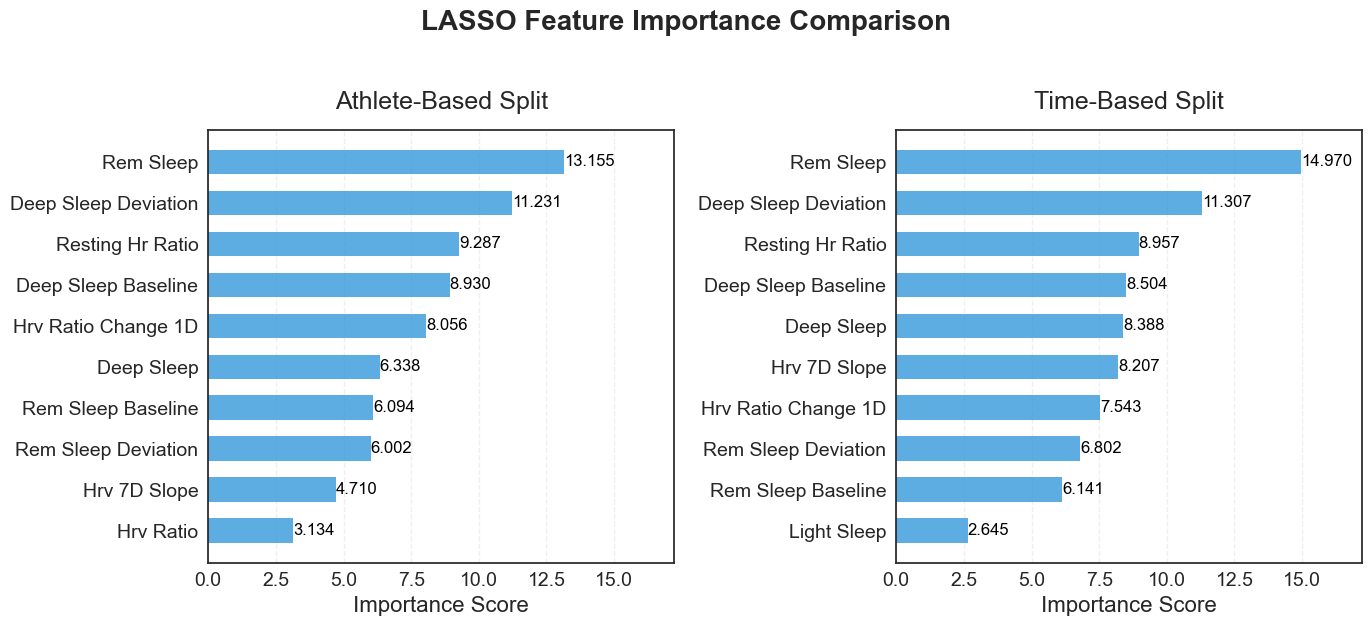

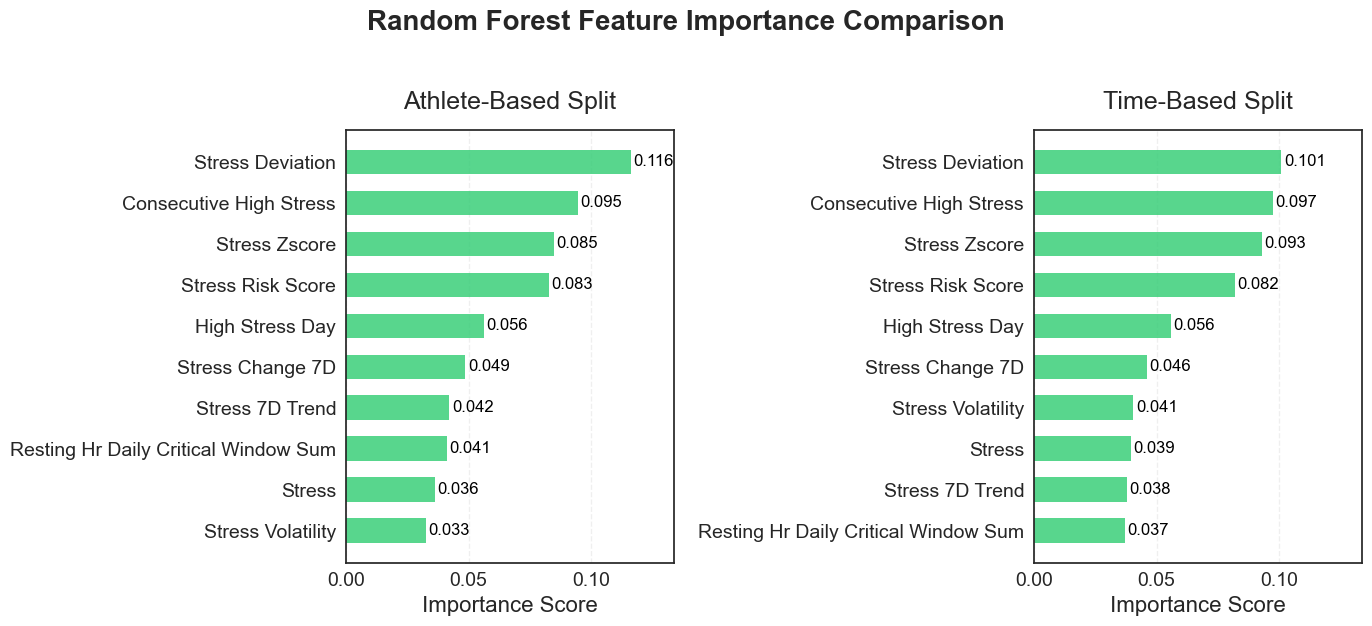

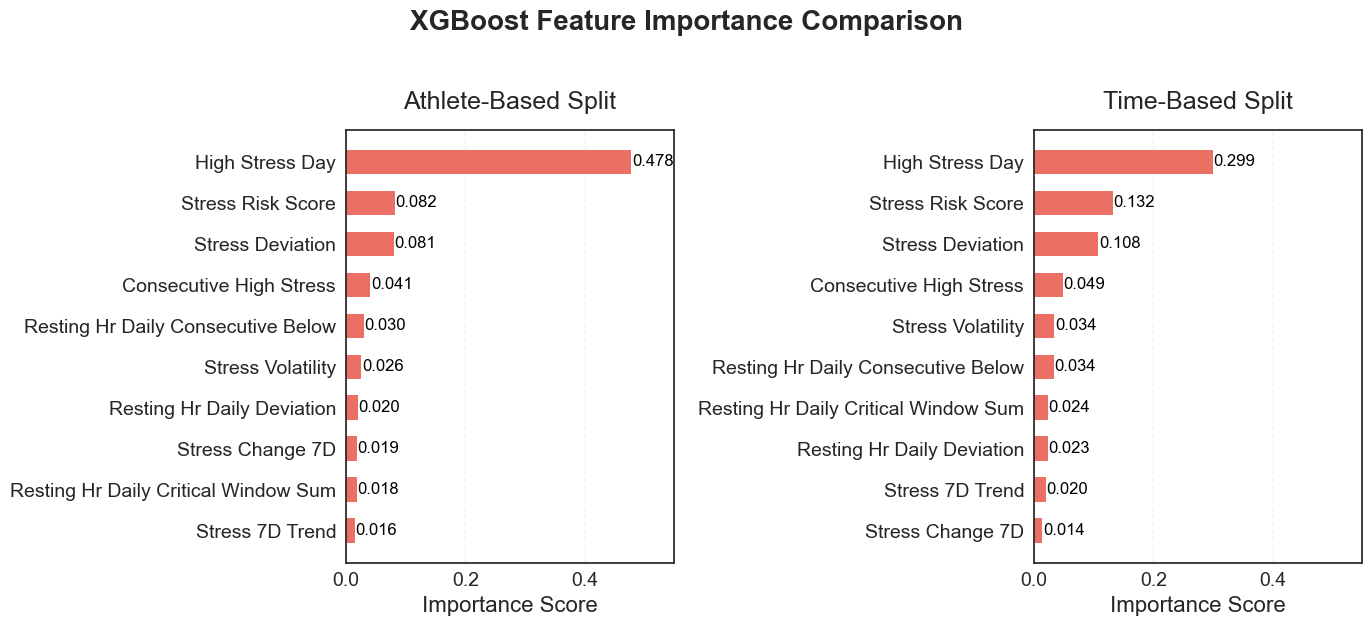


LASSO Top 5 Features Table

LaTeX Table:
\begin{tabular}{c|l|c|l|c}
\toprule
Rank & Feature (Athlete Split) & Importance (Athlete) & Feature (Time Split) & Importance (Time) \\
\midrule
1 & Rem Sleep & 13.155 & Rem Sleep & 14.970 \\
2 & Deep Sleep Deviation & 11.231 & Deep Sleep Deviation & 11.307 \\
3 & Resting Hr Ratio & 9.287 & Resting Hr Ratio & 8.957 \\
4 & Deep Sleep Baseline & 8.930 & Deep Sleep Baseline & 8.504 \\
5 & Hrv Ratio Change 1D & 8.056 & Deep Sleep & 8.388 \\
\bottomrule
\end{tabular}


Random Forest Top 5 Features Table

LaTeX Table:
\begin{tabular}{c|l|c|l|c}
\toprule
Rank & Feature (Athlete Split) & Importance (Athlete) & Feature (Time Split) & Importance (Time) \\
\midrule
1 & Stress Deviation & 0.116 & Stress Deviation & 0.101 \\
2 & Consecutive High Stress & 0.095 & Consecutive High Stress & 0.097 \\
3 & Stress Zscore & 0.085 & Stress Zscore & 0.093 \\
4 & Stress Risk Score & 0.083 & Stress Risk Score & 0.082 \\
5 & High Stress Day & 0.056 & High Stress Day & 0

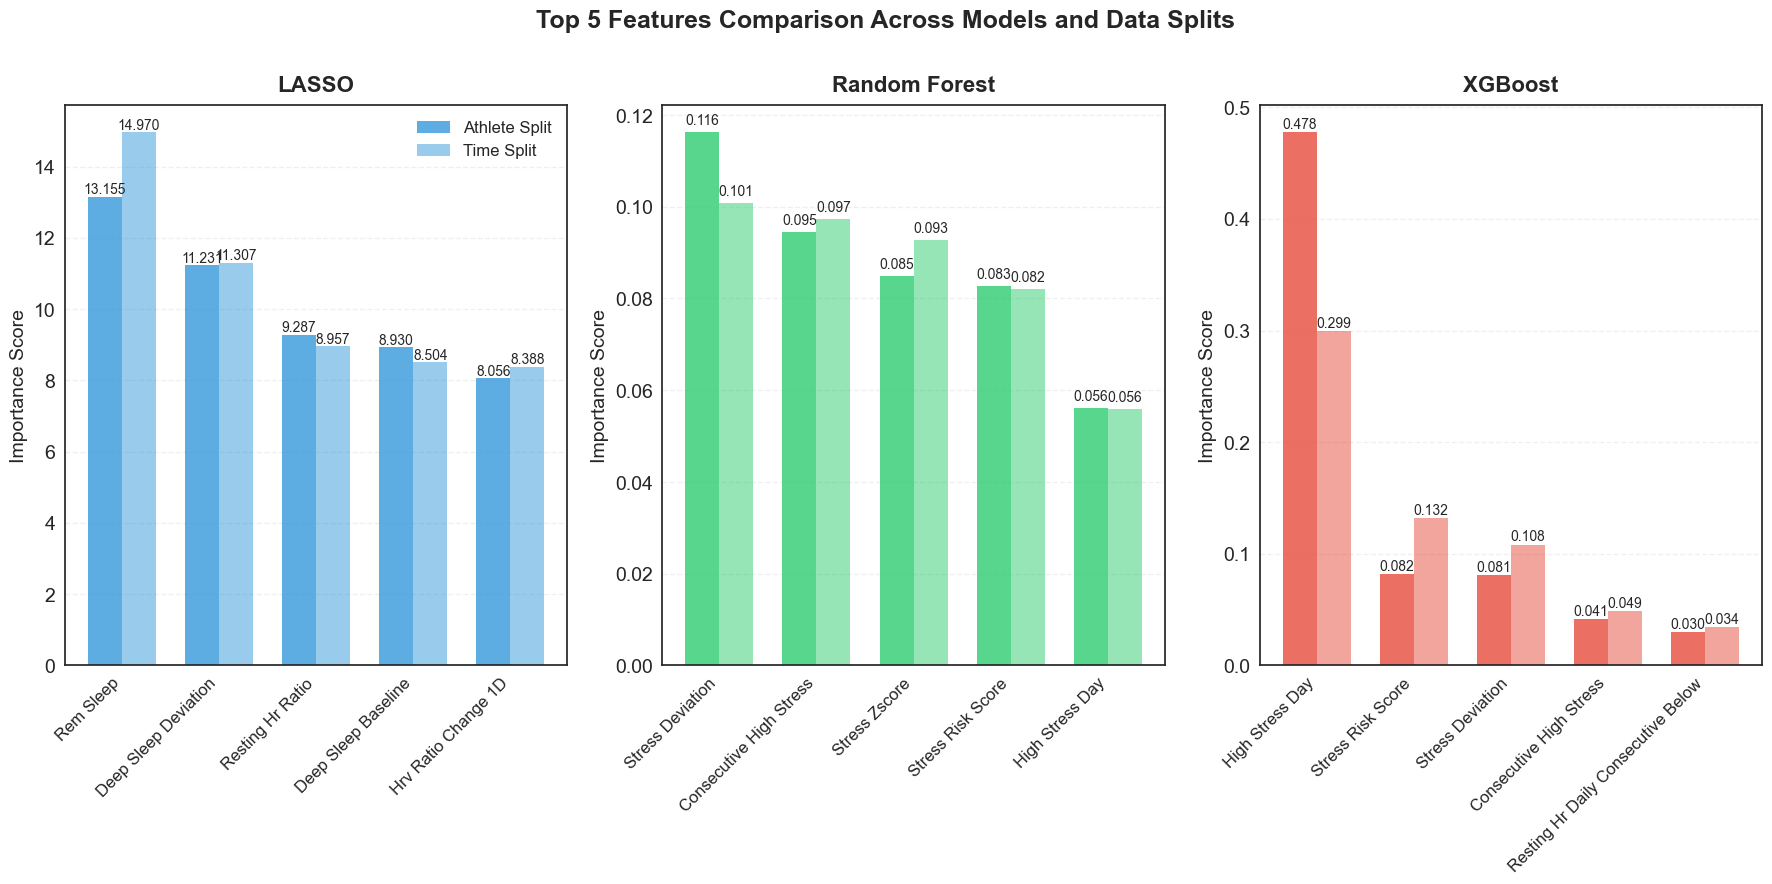

In [25]:
def create_thesis_friendly_comparison(results_athlete, results_time, top_n=10):
    """Create separate plots for each model for better readability in thesis."""
    
    # Set a professional style
    plt.style.use('seaborn-v0_8-white')
    
    models = ['LASSO', 'Random Forest', 'XGBoost']
    colors = {
        'LASSO': '#3498db',    # Blue
        'Random Forest': '#2ecc71',  # Green
        'XGBoost': '#e74c3c'  # Red
    }
    
    # Create individual plots for each model
    for model in models:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
        fig.suptitle(f'{model} Feature Importance Comparison', 
                     fontsize=20, fontweight='bold', y=1.05)
        
        # Athlete Split
        importance_athlete = results_athlete[model]['feature_importance'].head(top_n)
        bars1 = ax1.barh(range(top_n), importance_athlete['Importance'], 
                        color=colors[model], alpha=0.8, height=0.6)
        
        feature_names_athlete = [name.replace('_', ' ').title() for name in importance_athlete['Feature']]
        ax1.set_yticks(range(top_n))
        ax1.set_yticklabels(feature_names_athlete, fontsize=14)
        ax1.invert_yaxis()
        ax1.set_xlabel('Importance Score', fontsize=16)
        ax1.set_title('Athlete-Based Split', fontsize=18, pad=15)
        ax1.grid(axis='x', alpha=0.3, linestyle='--')
        
        # Add value labels
        for bar, value in zip(bars1, importance_athlete['Importance']):
            width = bar.get_width()
            ax1.text(width + 0.001, bar.get_y() + bar.get_height()/2, 
                    f'{value:.3f}', va='center', fontsize=12, color='black')
        
        # Time Split
        importance_time = results_time[model]['feature_importance'].head(top_n)
        bars2 = ax2.barh(range(top_n), importance_time['Importance'], 
                        color=colors[model], alpha=0.8, height=0.6)
        
        feature_names_time = [name.replace('_', ' ').title() for name in importance_time['Feature']]
        ax2.set_yticks(range(top_n))
        ax2.set_yticklabels(feature_names_time, fontsize=14)
        ax2.invert_yaxis()
        ax2.set_xlabel('Importance Score', fontsize=16)
        ax2.set_title('Time-Based Split', fontsize=18, pad=15)
        ax2.grid(axis='x', alpha=0.3, linestyle='--')
        
        # Add value labels
        for bar, value in zip(bars2, importance_time['Importance']):
            width = bar.get_width()
            ax2.text(width + 0.001, bar.get_y() + bar.get_height()/2, 
                    f'{value:.3f}', va='center', fontsize=12, color='black')
        
        # Make x-axis consistent
        max_val = max(importance_athlete['Importance'].max(), 
                     importance_time['Importance'].max()) * 1.15
        ax1.set_xlim(0, max_val)
        ax2.set_xlim(0, max_val)
        
        plt.tight_layout()
        plt.subplots_adjust(top=0.85)
        
        # Save individual plots
        plt.show()
        plt.close()


def create_top_features_table(results_athlete, results_time, top_n=5):
    """Create LaTeX-ready tables for top features."""
    
    models = ['LASSO', 'Random Forest', 'XGBoost']
    
    for model in models:
        print(f"\n{model} Top {top_n} Features Table")
        print("="*50)
        
        # Create table data
        data = []
        
        # Athlete split features
        athlete_features = results_athlete[model]['feature_importance'].head(top_n)
        for rank, (_, row) in enumerate(athlete_features.iterrows(), 1):
            data.append({
                'Rank': rank,
                'Feature (Athlete Split)': row['Feature'].replace('_', ' ').title(),
                'Importance (Athlete)': f"{row['Importance']:.3f}"
            })
        
        # Time split features
        time_features = results_time[model]['feature_importance'].head(top_n)
        for idx, (_, row) in enumerate(time_features.iterrows()):
            if idx < len(data):
                data[idx]['Feature (Time Split)'] = row['Feature'].replace('_', ' ').title()
                data[idx]['Importance (Time)'] = f"{row['Importance']:.3f}"
        
        # Convert to DataFrame
        df = pd.DataFrame(data)
        
        # Print as LaTeX
        print("\nLaTeX Table:")
        print(df.to_latex(index=False, escape=False, 
                         column_format='c|l|c|l|c'))
        
        # Also save as CSV
        df.to_csv(f'{model.lower().replace(" ", "_")}_top_features.csv', index=False)


def create_compact_summary_plot(results_athlete, results_time, top_n=5):
    """Create a compact summary plot showing only the most important features."""
    
    fig, axes = plt.subplots(1, 3, figsize=(18, 8))
    
    models = ['LASSO', 'Random Forest', 'XGBoost']
    colors = ['#3498db', '#2ecc71', '#e74c3c']
    
    for i, (model, color) in enumerate(zip(models, colors)):
        ax = axes[i]
        
        # Get top features from both splits
        athlete_imp = results_athlete[model]['feature_importance'].head(top_n)
        time_imp = results_time[model]['feature_importance'].head(top_n)
        
        # Create grouped bar chart
        x = np.arange(top_n)
        width = 0.35
        
        # Plot bars
        bars1 = ax.bar(x - width/2, athlete_imp['Importance'], width, 
                      label='Athlete Split', color=color, alpha=0.8)
        bars2 = ax.bar(x + width/2, time_imp['Importance'], width, 
                      label='Time Split', color=color, alpha=0.5)
        
        # Format x-axis
        feature_names = [name.replace('_', ' ').title() for name in athlete_imp['Feature']]
        ax.set_xticks(x)
        ax.set_xticklabels(feature_names, rotation=45, ha='right', fontsize=12)
        
        # Format y-axis
        ax.set_ylabel('Importance Score', fontsize=14)
        ax.set_title(model, fontsize=16, fontweight='bold', pad=10)
        ax.grid(axis='y', alpha=0.3, linestyle='--')
        
        # Add legend only to first subplot
        if i == 0:
            ax.legend(fontsize=12)
        
        # Add value labels on bars
        for bars in [bars1, bars2]:
            for bar in bars:
                height = bar.get_height()
                if height > 0.01:
                    ax.text(bar.get_x() + bar.get_width()/2., height + 0.001,
                           f'{height:.3f}', ha='center', va='bottom', fontsize=10)
    
    plt.suptitle('Top 5 Features Comparison Across Models and Data Splits', 
                 fontsize=18, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.subplots_adjust(top=0.9, bottom=0.2)
    plt.show()


# Usage examples:
create_thesis_friendly_comparison(results_athlete, results_time, top_n=10)
create_top_features_table(results_athlete, results_time, top_n=5)
create_compact_summary_plot(results_athlete, results_time, top_n=5)